# Robotic Navigation Toy Problem
This notebook imports a map image (created by ppt) and converts it to a graph.     
The nodes are the coordinate of accessible positions in the map and the edges are discrete actions (up, down, left and right).    
The first part demonstrates how a shortest path search in the networkx package scales on the grid size. 

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
import time

In [5]:
from networkx.algorithms.shortest_paths.generic import shortest_path

def maxpool(img, window_size=50):
    newrows = img.shape[0]//window_size+1
    newcols = img.shape[1]//window_size+1
    newimg = np.zeros((newrows,newcols))
    for row in range(newrows):
        for col in range(newcols):
            newimg[row,col] = np.max(img[row*window_size:(row+1)*window_size,col*window_size:(col+1)*window_size])
    return newimg      

def coarse_map(map_orig, poolsize=5):
    return np.concatenate([np.expand_dims(maxpool(map_orig[:,:,0],poolsize),-1),np.expand_dims(maxpool(map_orig[:,:,1],poolsize),-1),np.expand_dims(maxpool(map_orig[:,:,2],poolsize),-1)],axis=-1)

def extract_edges(node_coords):
    edges=[]
    for i in range(1,node_coords[:,0].max()+1): #row sweep
        indexes=np.argwhere(node_coords[:,0]==i).T[0] 
        for k in range(1,len(indexes)):
            if abs(node_coords[indexes[k],1]-node_coords[indexes[k-1],1])==1:
                edges.append((indexes[k-1],indexes[k]))
    for j in range(1,node_coords[:,1].max()+1): #col sweep
        indexes=np.argwhere(node_coords[:,1]==j).T[0]       
        for k in range(1,len(indexes)):
            if abs(node_coords[indexes[k],0]-node_coords[indexes[k-1],0])==1:
                edges.append((indexes[k-1],indexes[k]))
    return edges   

def find_index(lst,val):
    for i in range(len(lst)):
        el=lst[i]           
        if (abs(el[0]-val[0])<=1)&(abs(el[1]-val[1])<=1):
            return i
            

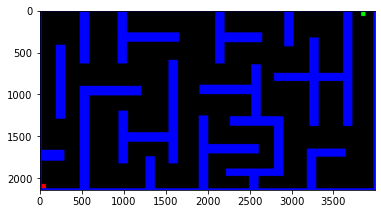

In [6]:
maze = plt.imread('maps/map1.jpg')
# create start and goal regions. It is manually created after inspecting the map
maze[2064:2114,21:71,1] = 1 #start region
maze[21:71, 3825:3875, 2] = 1 #goal
plt.imshow(maze[:,:,1:]) 

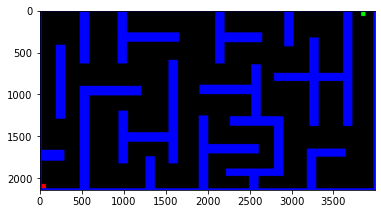

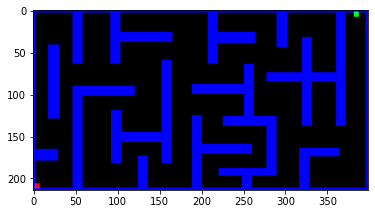

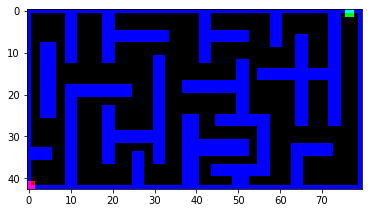

In [8]:
# The image from ppt has 4 channels, so I had to choose 3 channels for the start region, goal region, and the walls (mz0 below)
# The start and goal regions were manually selected after visual inspection of the map, and they are more than 1 pixels for visualization purposes. 
# If we use a different maze generating tool, perhaps different preprocessing may be needed.
# Below shows the resulting maps when we coarsen the original grid (2136 x 3989) by subsampling by 10 and 50 pixels in each row and cols.
mz0=maze[:,:,1:]
mz10 = coarse_map(mz0,10)
mz50 = coarse_map(mz0,50)
plt.imshow(mz0)
plt.show()
plt.imshow(mz10)
plt.show()
plt.imshow(mz50)
plt.show()

In [7]:
def calc_shortest_path(grid):
    node_coords = np.argwhere(1-grid[:,:,2])
    print(len(node_coords), 'nodes.')
    ##  extract edges
    t0=time.perf_counter()
    edges = extract_edges(node_coords)
    t1=time.perf_counter()
    print(len(edges), 'edges extracted', t1-t0, 's.')
    t0=time.perf_counter()
    G=nx.Graph()
    G.add_nodes_from(range(len(node_coords)))
    G.add_edges_from(edges)
    t1=time.perf_counter()
    print('Graph created', t1-t0, 's.') 
    source = find_index(node_coords,np.argwhere(grid[:,:,0]*(1-grid[:,:,2]))[0]) # since source and target node need to be unique, it chooses one node out of the region
    target = find_index(node_coords,np.argwhere(grid[:,:,1]*(1-grid[:,:,2]))[0])
    print('source', source,'target', target)
    t0=time.perf_counter()
    sp = shortest_path(G,source,target)
    t1=time.perf_counter()
    print('Shortest path with length', len(sp), t1-t0,'s.')
    return sp, G

In [8]:
sp50, G50 = calc_shortest_path(mz50)

2081 nodes.
3681 edges extracted 0.014467937406152487 s.
Graph created 0.015036707278341055 s.
source 1959 target 59
Shortest path with length 154 0.003316329326480627 s.


In [9]:
import copy
def display(grid,sp):
    node_coords = np.argwhere(1-grid[:,:,2])
    overlay = copy.deepcopy(grid)
    for i in sp:
        x = node_coords[i]
        overlay[x[0],x[1],0]=1
        overlay[x[0],x[1],1]=1
    plt.imshow(overlay) 

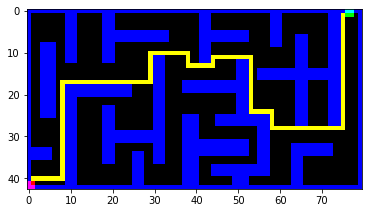

In [10]:
display(mz50,sp50)

60845 nodes.
119303 edges extracted 0.1927730138413608 s.
Graph created 0.44308784417808056 s.
source 58847 target 318
Shortest path with length 743 0.08026532828807831 s.


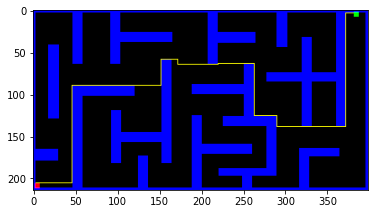

In [11]:
sp10, G10 = calc_shortest_path(mz10)
display(mz10,sp10)

6310323 nodes.
12596752 edges extracted 49.22425459418446 s.
Graph created 55.98783804709092 s.
source 6134355 target 3243
Shortest path with length 7418 11.624448920134455 s.


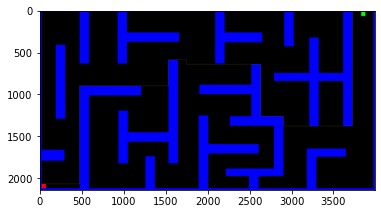

In [12]:
sp0, G0 = calc_shortest_path(mz0)
display(mz0,sp0) 

In [13]:
print(mz0.shape)
print(mz10.shape)
print(mz50.shape)

(2136, 3989, 3)
(214, 399, 3)
(43, 80, 3)


## Conclusion
In this experiment, I showed how time scales on coarsened grids.

|Coarsening|None|10|50|
|:-------:|:---------------:|:----------:|:---------:|
| grid size|2136x3989 | 214x399|43x80|
|num nodes|6.3M|61k|2k|
|num edges|12.6M|119k|3.7k|
|time edge created| 51s | 0.17s|0.015s|
|time graph created| 64s | 0.5 s|0.013s|
|time shortest path| 12.5s|0.08s|0.003s|
|shortest path length|7418|743|154|

Shortest path calculation on a grid with 12M edges didn't take long.    
It seems that there is not much advantage of using GNN to calculate shortest path on this 10M edge sized map.    
Perhaps if it becomes 3D or bigger action space, it's more useful to coarsen.    
Also it assumes grids are known and accurate. In real world, grid may be estimated from measurements.    
But to do that an agent need to explore all area and accurately map the walls and objects.    
Also when there is a moving object (or its location changes occasionally), then, the agent needs to do the mapping and searching again. (well, is it different when we use GNN?)    
Perhaps in a dynamically changing environment, it is better to have a short-term plan. Such as identify turn or corner, then go there then look around.  

For project purpose, we prioritize two tasks: graph abstraction (supergraph generation) and node feature calculation to make the agent move along the middle part of the corridor (not getting too close to the wall).  

In [17]:
node_coords.shape

(6310323, 2)

In [22]:
import torch

In [17]:
len(G0.nodes)

6310323

In [19]:
len(G0.edges)

12596752

In [23]:
edges_np = np.array(G0.edges)
edges_t = torch.from_numpy(edges_np.T) # torch tensor's dtype is set to int64 in this case

In [43]:
G0.degree[0]

2

In [11]:
def extract_edges_and_features_from_image(node_coords):
    node_degree={}
    edges=[]
    edge_features=[]
    for i in range(1,node_coords[:,0].max()+1): #row sweep
        indexes=np.argwhere(node_coords[:,0]==i).T[0] 
        for k in range(1,len(indexes)):
            if abs(node_coords[indexes[k],1]-node_coords[indexes[k-1],1])==1:
                edges.append((indexes[k-1],indexes[k]))
                edges.append((indexes[k],indexes[k-1]))
                edge_features.append((0,1)) #right (row,col)
                edge_features.append((0,-1)) #left
                for m in [k-1,k]:
                    idx = indexes[m]
                    if idx in node_degree.keys():
                        val = node_degree[idx]
                        node_degree.update({idx:val+1})  
                    else:
                        node_degree.update({idx:1})
    for j in range(1,node_coords[:,1].max()+1): #col sweep
        indexes=np.argwhere(node_coords[:,1]==j).T[0]       
        for k in range(1,len(indexes)):
            if abs(node_coords[indexes[k],0]-node_coords[indexes[k-1],0])==1:
                edges.append((indexes[k-1],indexes[k]))
                edges.append((indexes[k],indexes[k-1]))
                edge_features.append((0,-1)) #down
                edge_features.append((0,1)) #up
                for m in [k-1,k]:
                    idx = indexes[m]
                    if idx in node_degree.keys():
                        val = node_degree[idx]
                        node_degree.update({idx:val+1})                        
                    else:
                        node_degree.update({idx:1})
    return edges, edge_features, node_degree  

def extract_edges_and_features_from_image2(node_coords):
#     node_degree=dict({})
    edges=dict({})
    edge_features=dict({})
    t0=time.perf_counter()
    for i in range(1,node_coords[:,0].max()+1): #row sweep
        indexes=np.argwhere(node_coords[:,0]==i).T[0] 
        for k in range(1,len(indexes)):
            if abs(node_coords[indexes[k],1]-node_coords[indexes[k-1],1])==1:
                if indexes[k-1] in edges.keys():
                    e = edges[indexes[k-1]]
                    e.append((indexes[k-1],indexes[k]))
                    f = edge_features[indexes[k-1]]
                    f.append((0,1)) # move to right
                    edges.update({indexes[k-1]:e})
                    edge_features.update({indexes[k-1]:f}) 
                else:
                    edges.update({indexes[k-1]:[(indexes[k-1],indexes[k])]})
                    edge_features.update({indexes[k-1]:[(0,1)]})
                if indexes[k] in edges.keys():
                    e = edges[indexes[k]]
                    e.append((indexes[k],indexes[k-1]))
                    f = edge_features[indexes[k]]
                    f.append((0,-1)) # move to left
                    edges.update({indexes[k]:e})
                    edge_features.update({indexes[k]:f}) 
                else:
                    edges.update({indexes[k]:[(indexes[k],indexes[k-1])]})   
                    edge_features.update({indexes[k]:[(0,-1)]}) 

#                 for m in [k-1,k]:
#                     idx = indexes[m]
#                     if idx in node_degree.keys():
#                         val = node_degree[idx]
#                         node_degree.update({idx:val+1})  
#                     else:
#                         node_degree.update({idx:1})
                        
    for j in range(1,node_coords[:,1].max()+1): #col sweep
        indexes=np.argwhere(node_coords[:,1]==j).T[0]       
        for k in range(1,len(indexes)):
            if abs(node_coords[indexes[k],0]-node_coords[indexes[k-1],0])==1:
                if indexes[k-1] in edges.keys():
                    e = edges[indexes[k-1]]
                    e.append((indexes[k-1],indexes[k]))
                    f = edge_features[indexes[k-1]]
                    f.append((1,0)) # move down
                    edges.update({indexes[k-1]:e})
                    edge_features.update({indexes[k-1]:f}) 
                else:
                    edges.update({indexes[k-1]:[(indexes[k-1],indexes[k])]})
                    edge_features.update({indexes[k-1]:[(1,0)]})
                if indexes[k] in edges.keys():
                    e = edges[indexes[k]]
                    e.append((indexes[k],indexes[k-1]))
                    f = edge_features[indexes[k]]
                    f.append((-1,0)) # move up
                    edges.update({indexes[k]:e})
                    edge_features.update({indexes[k]:f}) 
                else:
                    edges.update({indexes[k]:[(indexes[k],indexes[k-1])]})    
                    edge_features.update({indexes[k]:[(-1,0)]}) 
                
#                 for m in [k-1,k]:
#                     idx = indexes[m]
#                     if idx in node_degree.keys():
#                         val = node_degree[idx]
#                         node_degree.update({idx:val+1})                        
#                     else:
#                         node_degree.update({idx:1})
    t1=time.perf_counter()
    print('dicts created',t1-t0)
    #sanity checks
    print(type(edges),type(edge_features))
    assert len(edges)==len(edge_features), 'numbers of nodes in edge index and edge features do not match'
    num_nodes=len(edges)
    edges = dictsort(edges)
    edge_features = dictsort(edge_features)
    edges_out=[]
    edge_features_out=[]
    node_degree_out=[]
    print(len(edges))
    t0=time.perf_counter()
    for n in range(len(edges)):
        if n%1000==0:
            t1=time.perf_counter()
            print(n,'/',num_nodes,t1-t0)
        assert n==edges[n][0],'edge node index not match'
        assert n==edge_features[n][0],'edge feature node index not match'
        assert len(edges[n][1])==len(edge_features[n][1]),'number of edges and number of edge features do not match'
        edges_out.extend(edges[n][1])
        edge_features_out.extend(edge_features[n][1])
        node_degree_out.append(len(edges[n][1]))
    return edges_out, edge_features_out, node_degree_out   

def dictsort(d):
    items = d.items()
    return sorted(items)

In [175]:
len(node_coords)

60845

In [176]:
node_coords = np.argwhere(1-mz10[:,:,2])


In [177]:
import time
t0 = time.perf_counter()
edges, edge_features, node_degree = extract_edges_and_features_from_image2(node_coords)
t1 = time.perf_counter()
print(t1-t0)

dicts created 0.6329947682097554
<class 'dict'> <class 'dict'>
60845
0 / 60845 4.7693029046058655e-06
1000 / 60845 0.0017451150342822075
2000 / 60845 0.0032264813780784607
3000 / 60845 0.004784740973263979
4000 / 60845 0.006274775136262178
5000 / 60845 0.00785351824015379
6000 / 60845 0.009868829976767302
7000 / 60845 0.011678111273795366
8000 / 60845 0.013304393272846937
9000 / 60845 0.01503759901970625
10000 / 60845 0.0165399182587862
11000 / 60845 0.01813420234248042
12000 / 60845 0.01985435839742422
13000 / 60845 0.021378387231379747
14000 / 60845 0.02323909616097808
15000 / 60845 0.02475440828129649
16000 / 60845 0.026398230344057083
17000 / 60845 0.027947380207479
18000 / 60845 0.029507078230381012
19000 / 60845 0.031229857355356216
20000 / 60845 0.03339168801903725
21000 / 60845 0.03495480725541711
22000 / 60845 0.036833190359175205
23000 / 60845 0.03836240526288748
24000 / 60845 0.03980111517012119
25000 / 60845 0.041226412169635296
26000 / 60845 0.04291540337726474
27000 / 608

In [178]:
features = np.array(node_degree)
features.shape

(60845,)

In [38]:
features[0]

2

In [41]:
degree2 = np.argwhere(features==2)[:,0]

In [42]:
degree2

array([   0,    7,    8,   13,   14,   33,   34,   47,   48,   58,   59,
         62,  203,  223,  379,  399,  704,  705,  709,  851,  897,  898,
        902,  998, 1023, 1228, 1229, 1397, 1405, 1423, 1516, 1592, 1606,
       1614, 1718, 1737, 1750, 1787, 1996, 1997, 2020, 2027, 2028, 2040,
       2041, 2049, 2050, 2057, 2058, 2067, 2068, 2080])

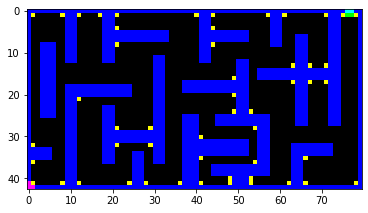

In [43]:
import copy
#node_coords = np.argwhere(1-grid[:,:,2])
overlay = copy.deepcopy(mz50)
for i in degree2:
    x = node_coords[i]
    overlay[x[0],x[1],0]=1
    overlay[x[0],x[1],1]=1
plt.imshow(overlay) 

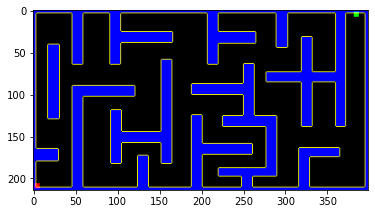

In [51]:
degree3 = np.argwhere(features==3)[:,0]
overlay = copy.deepcopy(mz10)
for i in degree3:
    x = node_coords[i]
    overlay[x[0],x[1],0]=1
    overlay[x[0],x[1],1]=1
plt.imshow(overlay) 

In [179]:
import torch
from torch_geometric.data import Data

t0=time.perf_counter()
edge_index = torch.tensor(edges, dtype=torch.long)
edge_features = torch.tensor(edge_features, dtype=torch.long)
node_features = node_features = torch.tensor(node_coords, dtype=torch.float)  #torch.tensor(np.expand_dims(np.array(node_degree),-1), dtype=torch.float)
t1=time.perf_counter()
print(t1-t0)


0.12982744071632624


In [181]:
node_features.shape

torch.Size([60845, 2])

In [180]:
edge_index.shape

torch.Size([238606, 2])

In [183]:
edge_index[4000:4010]

tensor([[1093,  760],
        [1093, 1426],
        [1094, 1093],
        [1094, 1095],
        [1094,  761],
        [1094, 1427],
        [1095, 1094],
        [1095, 1096],
        [1095,  762],
        [1095, 1428]])

In [184]:
data = Data(x=node_features, edge_index=edge_index.t().contiguous(), edge_features = edge_features)

In [64]:
from torch_geometric.utils import degree
dv = degree(data.edge_index.reshape(data.edge_index.shape[1]*2,)) #the operation is very fast, it seems it counts

In [60]:
dv #doubled

tensor([4., 6., 6.,  ..., 6., 6., 4.])

In [62]:
data.x

tensor([[2.],
        [3.],
        [3.],
        ...,
        [3.],
        [3.],
        [2.]])

In [498]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric import nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args.heads * hidden_dim, hidden_dim), nn.Dropout(args.dropout), 
            nn.Linear(hidden_dim, output_dim)) 
        
        self.dropout = args.dropout
        self.num_layers = args.num_layers

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            # When applying GAT with num heads > 1, you need to modify the 
            # input and output dimension of the conv layers (self.convs),
            # to ensure that the input dim of the next layer is num heads
            # multiplied by the output dim of the previous layer.
            # HINT: In case you want to play with multiheads, you need to change the for-loop that builds up self.convs to be
            # self.convs.append(conv_model(hidden_dim * num_heads, hidden_dim)), 
            # and also the first nn.Linear(hidden_dim * num_heads, hidden_dim) in post-message-passing.
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout,training=self.training)

        x = self.post_mp(x)

        if self.emb == True:
            return x

        return F.softmax(x, dim=1)

    def loss(self, cluster_assignment, coords):
        loss=0
        cluster_size = torch.sum(cluster_assignment,axis=0).reshape(cluster_assignment.shape[1],1)
        centroids = torch.div(torch.matmul(cluster_assignment.t(),coords), cluster_size)
        print()
#         print('centro',centroids.shape, centroids)
        num_sum=0
        for k in range(cluster_assignment.shape[1]):
            xi = torch.masked_select(coords[:,0], cluster_assignment.max(axis=1).indices==k) #torch.masked_select(coords[:,0], cluster_assignment.ge(0.5)[:,k]) #none of the element is bigger than 0.5 initially
            yi = torch.masked_select(coords[:,1], cluster_assignment.max(axis=1).indices==k)
            coords_in_cluster = torch.concat((xi[:, None],yi[:, None]),axis=-1)
#             print(k,coords_in_cluster.shape)
#             print(k, centroids[k].shape)
#             print(k, (coords_in_cluster-centroids[k])**2)
            dist = torch.sum((coords_in_cluster-centroids[k])**2,axis=-1)
            print('dist',dist.shape)
            loss_k=torch.mean(dist) # mean squared distane within each cluster
            print('loss cal',k,loss_k, 'num_nodes in cluster', len(coords_in_cluster))
            num_sum+=len(coords_in_cluster)
            loss+=loss_k
        print('ca', cluster_assignment.shape)
        print(num_sum)    
       
        return loss   

In [153]:
a = torch.Tensor([[1,0],[0,1],[1,1],[-1,1],[0,0],[1,2],[2,1]]) #n=4, d=2 feature vector
b = torch.Tensor([[1,0,0],[0,1,0],[0,0,1],[0,1,0],[1,0,0],[0,0,1],[0,0,1]]) #n=4, k=3 assign mat
xm = torch.div(torch.matmul(b.t(),a),torch.sum(b,axis=0).reshape(3,1)) #centroids

In [434]:
batch.x.shape

torch.Size([2708, 1433])

In [154]:
xm

tensor([[ 0.5000,  0.0000],
        [-0.5000,  1.0000],
        [ 1.3333,  1.3333]])

In [102]:
mask = b>0.5
mask

tensor([[ True, False, False],
        [False,  True, False],
        [False, False,  True],
        [False,  True, False],
        [ True, False, False],
        [False, False,  True]])

In [147]:
torch.concat((xx[:, None],yy[:,None]),axis=-1)

tensor([[ 0.,  1.],
        [-1.,  1.]])

In [443]:
for i in range(3):
    xx = torch.masked_select(a[:,0], b.ge(0.5)[:,i])
    yy = torch.masked_select(a[:,1], b.ge(0.5)[:,i])
    xc = torch.concat((xx[:, None],yy[:,None]),axis=-1)
    print(i, torch.sum((xc-xm[i])**2,axis=-1))

0 tensor([0.2500, 0.2500])
1 tensor([0.2500, 0.2500])
2 tensor([0.2222, 0.5556, 0.5556])


In [81]:
torch.div(torch.matmul(b.t(),a),torch.sum(b,axis=0).reshape(3,1)) #centroids

tensor([[ 1.0000,  0.0000],
        [-0.5000,  1.0000],
        [ 1.0000,  1.0000]])

In [194]:
data

Data(x=[60845, 2], edge_index=[2, 238606], edge_features=[238606, 2])

In [418]:
class GraphSage(MessagePassing):
    
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        ############################################################################
        # TODO: Your code here! 
        # Define the layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding 
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated 
        #            message from neighbors.
        # Don't forget the bias!
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.lin_l = Linear(self.in_channels,self.out_channels, bias=bias)
        self.lin_r = Linear(self.in_channels,self.out_channels, bias=bias)
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. Call the propagate function to conduct the message passing.
        #    1.1 See the description of propagate above or the following link for more information: 
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We will only use the representation for neighbor nodes (x_j), so by default
        #        we pass the same representation for central and neighbor nodes as x=(x, x). 
        # 2. Update our node embedding with skip connection from the previous layer.
        # 3. If normalize is set, do L-2 normalization (defined in 
        #    torch.nn.functional)
        #
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        x_agg = self.propagate(edge_index, x=(x,x), size=size)
        out = self.lin_l(x)+self.lin_r(x_agg)
        if self.normalize:
            out = torch.nn.functional.normalize(out) 
        ############################################################################

        return out

    def message(self, x_j):

        out = None

        ############################################################################
        # TODO: Your code here! 
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on 
        # what message each neighboring node passes.
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):

        out = None

        # The axis along which to index number of nodes.
        node_dim = self.node_dim #I'm not sure where this is coming from

        ############################################################################
        # TODO: Your code here! 
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: 
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.

        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean') 
        ############################################################################
        return out

In [338]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

In [501]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim
from tqdm import trange
import pandas as pd
import copy

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
#from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
#     print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
#     print()
    test_loader = loader = DataLoader(dataset, batch_size=32, shuffle=True)#DataLoader(dataset, batch_size=args.batch_size, shuffle=False) #somehow it does not batch correctly

    # build model
    #model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes, args)
    model = GNNStack(2, args.hidden_dim, 5, args) #2: coord dim, 20: number of clusters
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    losses = []
    test_loss = []
    best_loss = 1. #0 choose carefully to something possible
    best_model =  copy.deepcopy(model) # None
    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        total_loss = 0
        model.train()
        ii=0
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
#             label = batch.y
            pred = pred[batch.train_mask]
            feat = batch.x[batch.train_mask]
#             label = label[batch.train_mask]
#             loss = model.loss(pred, label)
            loss = model.loss(pred,feat)
            print(epoch, ii, 'train batch loss', loss)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        losses.append(total_loss)
        
    ##GK
    #return losses

        if epoch % 10 == 0:
            print('test, ep',epoch)
            loss_test = test(test_loader, model)
            test_loss.append(loss_test)
            if loss_test < best_loss:
                best_loss = loss_test
                best_model = copy.deepcopy(model)
            else:
                best_model = copy.deepcopy(model)    #update anyway for now
        else:
            test_loss.append(test_loss[-1])
    
    return test_loss, losses, best_model, best_loss, test_loader

def test(loader, test_model, is_validation=False, save_model_preds=False, model_type=None):
    test_model.eval()

    correct = 0
    # Note that Cora is only one graph!
    total_loss=0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices ###GK- Noooo!
            pred = test_model(data) #.max(dim=1)[1]
            #label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        feat = data.x[mask]
        loss = test_model.loss(pred,feat)
        total_loss += loss.item() * batch.num_graphs
    total_loss /= len(loader.dataset)
        #label = label[mask]

#         if save_model_preds:
#             print ("Saving Model Predictions for Model Type", model_type)

#             data = {}
#             data['pred'] = pred.view(-1).cpu().detach().numpy()
#             data['label'] = label.view(-1).cpu().detach().numpy()

#             df = pd.DataFrame(data=data)
#           # Save locally as csv
#             df.to_csv('CORA-Node-' + model_type + '.csv', sep=',', index=False)
            
#         correct += pred.eq(label).sum().item()

#     total = 0
#     for data in loader.dataset:
#         total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return total_loss
#    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

Training:   0%|          | 0/100 [00:00<?, ?Epochs/s]


dist torch.Size([25130])
loss cal 0 tensor(0.1100, grad_fn=<MeanBackward0>) num_nodes in cluster 25130
dist torch.Size([481])
loss cal 1 tensor(0.1133, grad_fn=<MeanBackward0>) num_nodes in cluster 481
dist torch.Size([13674])
loss cal 2 tensor(0.1116, grad_fn=<MeanBackward0>) num_nodes in cluster 13674
dist torch.Size([3218])
loss cal 3 tensor(0.1161, grad_fn=<MeanBackward0>) num_nodes in cluster 3218
dist torch.Size([88])
loss cal 4 tensor(0.0993, grad_fn=<MeanBackward0>) num_nodes in cluster 88
ca torch.Size([42591, 5])
42591
0 0 train batch loss tensor(0.5504, grad_fn=<AddBackward0>)
test, ep 0


Training:   1%|          | 1/100 [00:00<01:02,  1.57Epochs/s]


dist torch.Size([17452])
loss cal 0 tensor(0.1135) num_nodes in cluster 17452
dist torch.Size([0])
loss cal 1 tensor(nan) num_nodes in cluster 0
dist torch.Size([802])
loss cal 2 tensor(0.0642) num_nodes in cluster 802
dist torch.Size([0])
loss cal 3 tensor(nan) num_nodes in cluster 0
dist torch.Size([0])
loss cal 4 tensor(nan) num_nodes in cluster 0
ca torch.Size([18254, 5])
18254

dist torch.Size([25038])
loss cal 0 tensor(0.1105, grad_fn=<MeanBackward0>) num_nodes in cluster 25038
dist torch.Size([511])
loss cal 1 tensor(0.1133, grad_fn=<MeanBackward0>) num_nodes in cluster 511
dist torch.Size([13859])
loss cal 2 tensor(0.1111, grad_fn=<MeanBackward0>) num_nodes in cluster 13859
dist torch.Size([3064])
loss cal 3 tensor(0.1153, grad_fn=<MeanBackward0>) num_nodes in cluster 3064
dist torch.Size([119])
loss cal 4 tensor(0.0840, grad_fn=<MeanBackward0>) num_nodes in cluster 119
ca torch.Size([42591, 5])
42591
1 0 train batch loss tensor(0.5341, grad_fn=<AddBackward0>)


Training:   3%|▎         | 3/100 [00:01<00:46,  2.08Epochs/s]


dist torch.Size([25558])
loss cal 0 tensor(0.1100, grad_fn=<MeanBackward0>) num_nodes in cluster 25558
dist torch.Size([534])
loss cal 1 tensor(0.1170, grad_fn=<MeanBackward0>) num_nodes in cluster 534
dist torch.Size([13421])
loss cal 2 tensor(0.1110, grad_fn=<MeanBackward0>) num_nodes in cluster 13421
dist torch.Size([2961])
loss cal 3 tensor(0.1185, grad_fn=<MeanBackward0>) num_nodes in cluster 2961
dist torch.Size([117])
loss cal 4 tensor(0.1039, grad_fn=<MeanBackward0>) num_nodes in cluster 117
ca torch.Size([42591, 5])
42591
2 0 train batch loss tensor(0.5604, grad_fn=<AddBackward0>)


Training:   4%|▍         | 4/100 [00:01<00:42,  2.25Epochs/s]


dist torch.Size([25657])
loss cal 0 tensor(0.1096, grad_fn=<MeanBackward0>) num_nodes in cluster 25657
dist torch.Size([631])
loss cal 1 tensor(0.1117, grad_fn=<MeanBackward0>) num_nodes in cluster 631
dist torch.Size([13260])
loss cal 2 tensor(0.1114, grad_fn=<MeanBackward0>) num_nodes in cluster 13260
dist torch.Size([2895])
loss cal 3 tensor(0.1206, grad_fn=<MeanBackward0>) num_nodes in cluster 2895
dist torch.Size([148])
loss cal 4 tensor(0.0965, grad_fn=<MeanBackward0>) num_nodes in cluster 148
ca torch.Size([42591, 5])
42591
3 0 train batch loss tensor(0.5498, grad_fn=<AddBackward0>)


Training:   5%|▌         | 5/100 [00:02<00:38,  2.47Epochs/s]


dist torch.Size([25597])
loss cal 0 tensor(0.1094, grad_fn=<MeanBackward0>) num_nodes in cluster 25597
dist torch.Size([623])
loss cal 1 tensor(0.1165, grad_fn=<MeanBackward0>) num_nodes in cluster 623
dist torch.Size([13443])
loss cal 2 tensor(0.1123, grad_fn=<MeanBackward0>) num_nodes in cluster 13443
dist torch.Size([2764])
loss cal 3 tensor(0.1170, grad_fn=<MeanBackward0>) num_nodes in cluster 2764
dist torch.Size([164])
loss cal 4 tensor(0.0948, grad_fn=<MeanBackward0>) num_nodes in cluster 164
ca torch.Size([42591, 5])
42591
4 0 train batch loss tensor(0.5499, grad_fn=<AddBackward0>)


Training:   6%|▌         | 6/100 [00:02<00:36,  2.60Epochs/s]


dist torch.Size([25879])
loss cal 0 tensor(0.1095, grad_fn=<MeanBackward0>) num_nodes in cluster 25879
dist torch.Size([677])
loss cal 1 tensor(0.1168, grad_fn=<MeanBackward0>) num_nodes in cluster 677
dist torch.Size([13053])
loss cal 2 tensor(0.1121, grad_fn=<MeanBackward0>) num_nodes in cluster 13053
dist torch.Size([2753])
loss cal 3 tensor(0.1153, grad_fn=<MeanBackward0>) num_nodes in cluster 2753
dist torch.Size([229])
loss cal 4 tensor(0.1052, grad_fn=<MeanBackward0>) num_nodes in cluster 229
ca torch.Size([42591, 5])
42591
5 0 train batch loss tensor(0.5590, grad_fn=<AddBackward0>)


Training:   7%|▋         | 7/100 [00:02<00:35,  2.65Epochs/s]


dist torch.Size([26118])
loss cal 0 tensor(0.1085, grad_fn=<MeanBackward0>) num_nodes in cluster 26118
dist torch.Size([790])
loss cal 1 tensor(0.1165, grad_fn=<MeanBackward0>) num_nodes in cluster 790
dist torch.Size([12725])
loss cal 2 tensor(0.1126, grad_fn=<MeanBackward0>) num_nodes in cluster 12725
dist torch.Size([2654])
loss cal 3 tensor(0.1209, grad_fn=<MeanBackward0>) num_nodes in cluster 2654
dist torch.Size([304])
loss cal 4 tensor(0.1004, grad_fn=<MeanBackward0>) num_nodes in cluster 304
ca torch.Size([42591, 5])
42591
6 0 train batch loss tensor(0.5590, grad_fn=<AddBackward0>)


Training:   8%|▊         | 8/100 [00:03<00:34,  2.67Epochs/s]


dist torch.Size([26019])
loss cal 0 tensor(0.1084, grad_fn=<MeanBackward0>) num_nodes in cluster 26019
dist torch.Size([872])
loss cal 1 tensor(0.1138, grad_fn=<MeanBackward0>) num_nodes in cluster 872
dist torch.Size([12602])
loss cal 2 tensor(0.1126, grad_fn=<MeanBackward0>) num_nodes in cluster 12602
dist torch.Size([2711])
loss cal 3 tensor(0.1203, grad_fn=<MeanBackward0>) num_nodes in cluster 2711
dist torch.Size([387])
loss cal 4 tensor(0.1022, grad_fn=<MeanBackward0>) num_nodes in cluster 387
ca torch.Size([42591, 5])
42591
7 0 train batch loss tensor(0.5574, grad_fn=<AddBackward0>)


Training:   9%|▉         | 9/100 [00:03<00:33,  2.68Epochs/s]


dist torch.Size([26080])
loss cal 0 tensor(0.1083, grad_fn=<MeanBackward0>) num_nodes in cluster 26080
dist torch.Size([904])
loss cal 1 tensor(0.1156, grad_fn=<MeanBackward0>) num_nodes in cluster 904
dist torch.Size([12402])
loss cal 2 tensor(0.1123, grad_fn=<MeanBackward0>) num_nodes in cluster 12402
dist torch.Size([2734])
loss cal 3 tensor(0.1201, grad_fn=<MeanBackward0>) num_nodes in cluster 2734
dist torch.Size([471])
loss cal 4 tensor(0.0992, grad_fn=<MeanBackward0>) num_nodes in cluster 471
ca torch.Size([42591, 5])
42591
8 0 train batch loss tensor(0.5555, grad_fn=<AddBackward0>)

dist torch.Size([25956])
loss cal 0 tensor(0.1080, grad_fn=<MeanBackward0>) num_nodes in cluster 25956
dist torch.Size([1092])
loss cal 1 tensor(0.1165, grad_fn=<MeanBackward0>) num_nodes in cluster 1092
dist torch.Size([12120])
loss cal 2 tensor(0.1121, grad_fn=<MeanBackward0>) num_nodes in cluster 12120
dist torch.Size([2778])
loss cal 3 tensor(0.1190, grad_fn=<MeanBackward0>) num_nodes in cluste

Training:  10%|█         | 10/100 [00:04<00:34,  2.60Epochs/s]


dist torch.Size([25850])
loss cal 0 tensor(0.1074, grad_fn=<MeanBackward0>) num_nodes in cluster 25850
dist torch.Size([1211])
loss cal 1 tensor(0.1164, grad_fn=<MeanBackward0>) num_nodes in cluster 1211
dist torch.Size([11916])
loss cal 2 tensor(0.1119, grad_fn=<MeanBackward0>) num_nodes in cluster 11916
dist torch.Size([2855])
loss cal 3 tensor(0.1205, grad_fn=<MeanBackward0>) num_nodes in cluster 2855
dist torch.Size([759])
loss cal 4 tensor(0.1043, grad_fn=<MeanBackward0>) num_nodes in cluster 759
ca torch.Size([42591, 5])
42591
10 0 train batch loss tensor(0.5605, grad_fn=<AddBackward0>)
test, ep 10


Training:  11%|█         | 11/100 [00:04<00:38,  2.32Epochs/s]


dist torch.Size([12682])
loss cal 0 tensor(0.0878) num_nodes in cluster 12682
dist torch.Size([0])
loss cal 1 tensor(nan) num_nodes in cluster 0
dist torch.Size([5572])
loss cal 2 tensor(0.1561) num_nodes in cluster 5572
dist torch.Size([0])
loss cal 3 tensor(nan) num_nodes in cluster 0
dist torch.Size([0])
loss cal 4 tensor(nan) num_nodes in cluster 0
ca torch.Size([18254, 5])
18254

dist torch.Size([26128])
loss cal 0 tensor(0.1072, grad_fn=<MeanBackward0>) num_nodes in cluster 26128
dist torch.Size([1322])
loss cal 1 tensor(0.1157, grad_fn=<MeanBackward0>) num_nodes in cluster 1322
dist torch.Size([11293])
loss cal 2 tensor(0.1117, grad_fn=<MeanBackward0>) num_nodes in cluster 11293
dist torch.Size([2893])
loss cal 3 tensor(0.1218, grad_fn=<MeanBackward0>) num_nodes in cluster 2893
dist torch.Size([955])
loss cal 4 tensor(0.0980, grad_fn=<MeanBackward0>) num_nodes in cluster 955
ca torch.Size([42591, 5])
42591
11 0 train batch loss tensor(0.5545, grad_fn=<AddBackward0>)


Training:  13%|█▎        | 13/100 [00:05<00:32,  2.66Epochs/s]


dist torch.Size([26000])
loss cal 0 tensor(0.1068, grad_fn=<MeanBackward0>) num_nodes in cluster 26000
dist torch.Size([1449])
loss cal 1 tensor(0.1149, grad_fn=<MeanBackward0>) num_nodes in cluster 1449
dist torch.Size([11040])
loss cal 2 tensor(0.1120, grad_fn=<MeanBackward0>) num_nodes in cluster 11040
dist torch.Size([2883])
loss cal 3 tensor(0.1202, grad_fn=<MeanBackward0>) num_nodes in cluster 2883
dist torch.Size([1219])
loss cal 4 tensor(0.0994, grad_fn=<MeanBackward0>) num_nodes in cluster 1219
ca torch.Size([42591, 5])
42591
12 0 train batch loss tensor(0.5532, grad_fn=<AddBackward0>)


Training:  14%|█▍        | 14/100 [00:05<00:31,  2.71Epochs/s]


dist torch.Size([25933])
loss cal 0 tensor(0.1060, grad_fn=<MeanBackward0>) num_nodes in cluster 25933
dist torch.Size([1625])
loss cal 1 tensor(0.1138, grad_fn=<MeanBackward0>) num_nodes in cluster 1625
dist torch.Size([10588])
loss cal 2 tensor(0.1118, grad_fn=<MeanBackward0>) num_nodes in cluster 10588
dist torch.Size([3027])
loss cal 3 tensor(0.1217, grad_fn=<MeanBackward0>) num_nodes in cluster 3027
dist torch.Size([1418])
loss cal 4 tensor(0.0987, grad_fn=<MeanBackward0>) num_nodes in cluster 1418
ca torch.Size([42591, 5])
42591
13 0 train batch loss tensor(0.5522, grad_fn=<AddBackward0>)


Training:  15%|█▌        | 15/100 [00:05<00:30,  2.79Epochs/s]


dist torch.Size([25796])
loss cal 0 tensor(0.1056, grad_fn=<MeanBackward0>) num_nodes in cluster 25796
dist torch.Size([1754])
loss cal 1 tensor(0.1084, grad_fn=<MeanBackward0>) num_nodes in cluster 1754
dist torch.Size([10218])
loss cal 2 tensor(0.1125, grad_fn=<MeanBackward0>) num_nodes in cluster 10218
dist torch.Size([3112])
loss cal 3 tensor(0.1225, grad_fn=<MeanBackward0>) num_nodes in cluster 3112
dist torch.Size([1711])
loss cal 4 tensor(0.0965, grad_fn=<MeanBackward0>) num_nodes in cluster 1711
ca torch.Size([42591, 5])
42591
14 0 train batch loss tensor(0.5455, grad_fn=<AddBackward0>)


Training:  16%|█▌        | 16/100 [00:06<00:29,  2.87Epochs/s]


dist torch.Size([25855])
loss cal 0 tensor(0.1045, grad_fn=<MeanBackward0>) num_nodes in cluster 25855
dist torch.Size([2000])
loss cal 1 tensor(0.1137, grad_fn=<MeanBackward0>) num_nodes in cluster 2000
dist torch.Size([9573])
loss cal 2 tensor(0.1126, grad_fn=<MeanBackward0>) num_nodes in cluster 9573
dist torch.Size([3190])
loss cal 3 tensor(0.1197, grad_fn=<MeanBackward0>) num_nodes in cluster 3190
dist torch.Size([1973])
loss cal 4 tensor(0.0982, grad_fn=<MeanBackward0>) num_nodes in cluster 1973
ca torch.Size([42591, 5])
42591
15 0 train batch loss tensor(0.5487, grad_fn=<AddBackward0>)


Training:  17%|█▋        | 17/100 [00:06<00:28,  2.93Epochs/s]


dist torch.Size([25865])
loss cal 0 tensor(0.1041, grad_fn=<MeanBackward0>) num_nodes in cluster 25865
dist torch.Size([2184])
loss cal 1 tensor(0.1105, grad_fn=<MeanBackward0>) num_nodes in cluster 2184
dist torch.Size([9169])
loss cal 2 tensor(0.1129, grad_fn=<MeanBackward0>) num_nodes in cluster 9169
dist torch.Size([3176])
loss cal 3 tensor(0.1200, grad_fn=<MeanBackward0>) num_nodes in cluster 3176
dist torch.Size([2197])
loss cal 4 tensor(0.0975, grad_fn=<MeanBackward0>) num_nodes in cluster 2197
ca torch.Size([42591, 5])
42591
16 0 train batch loss tensor(0.5451, grad_fn=<AddBackward0>)


Training:  18%|█▊        | 18/100 [00:06<00:27,  2.93Epochs/s]


dist torch.Size([25402])
loss cal 0 tensor(0.1036, grad_fn=<MeanBackward0>) num_nodes in cluster 25402
dist torch.Size([2257])
loss cal 1 tensor(0.1107, grad_fn=<MeanBackward0>) num_nodes in cluster 2257
dist torch.Size([8837])
loss cal 2 tensor(0.1131, grad_fn=<MeanBackward0>) num_nodes in cluster 8837
dist torch.Size([3358])
loss cal 3 tensor(0.1200, grad_fn=<MeanBackward0>) num_nodes in cluster 3358
dist torch.Size([2737])
loss cal 4 tensor(0.0925, grad_fn=<MeanBackward0>) num_nodes in cluster 2737
ca torch.Size([42591, 5])
42591
17 0 train batch loss tensor(0.5400, grad_fn=<AddBackward0>)


Training:  19%|█▉        | 19/100 [00:07<00:27,  2.98Epochs/s]


dist torch.Size([25462])
loss cal 0 tensor(0.1035, grad_fn=<MeanBackward0>) num_nodes in cluster 25462
dist torch.Size([2442])
loss cal 1 tensor(0.1075, grad_fn=<MeanBackward0>) num_nodes in cluster 2442
dist torch.Size([8211])
loss cal 2 tensor(0.1130, grad_fn=<MeanBackward0>) num_nodes in cluster 8211
dist torch.Size([3405])
loss cal 3 tensor(0.1173, grad_fn=<MeanBackward0>) num_nodes in cluster 3405
dist torch.Size([3071])
loss cal 4 tensor(0.0930, grad_fn=<MeanBackward0>) num_nodes in cluster 3071
ca torch.Size([42591, 5])
42591
18 0 train batch loss tensor(0.5343, grad_fn=<AddBackward0>)


Training:  20%|██        | 20/100 [00:07<00:26,  3.04Epochs/s]


dist torch.Size([25145])
loss cal 0 tensor(0.1019, grad_fn=<MeanBackward0>) num_nodes in cluster 25145
dist torch.Size([2623])
loss cal 1 tensor(0.1087, grad_fn=<MeanBackward0>) num_nodes in cluster 2623
dist torch.Size([7907])
loss cal 2 tensor(0.1131, grad_fn=<MeanBackward0>) num_nodes in cluster 7907
dist torch.Size([3500])
loss cal 3 tensor(0.1182, grad_fn=<MeanBackward0>) num_nodes in cluster 3500
dist torch.Size([3416])
loss cal 4 tensor(0.0933, grad_fn=<MeanBackward0>) num_nodes in cluster 3416
ca torch.Size([42591, 5])
42591
19 0 train batch loss tensor(0.5351, grad_fn=<AddBackward0>)

dist torch.Size([24786])
loss cal 0 tensor(0.1014, grad_fn=<MeanBackward0>) num_nodes in cluster 24786
dist torch.Size([2792])
loss cal 1 tensor(0.1059, grad_fn=<MeanBackward0>) num_nodes in cluster 2792
dist torch.Size([7535])
loss cal 2 tensor(0.1141, grad_fn=<MeanBackward0>) num_nodes in cluster 7535
dist torch.Size([3607])
loss cal 3 tensor(0.1185, grad_fn=<MeanBackward0>) num_nodes in clust

Training:  21%|██        | 21/100 [00:08<00:29,  2.64Epochs/s]


dist torch.Size([11322])
loss cal 0 tensor(0.0857) num_nodes in cluster 11322
dist torch.Size([0])
loss cal 1 tensor(nan) num_nodes in cluster 0
dist torch.Size([782])
loss cal 2 tensor(0.0867) num_nodes in cluster 782
dist torch.Size([6150])
loss cal 3 tensor(0.1225) num_nodes in cluster 6150
dist torch.Size([0])
loss cal 4 tensor(nan) num_nodes in cluster 0
ca torch.Size([18254, 5])
18254

dist torch.Size([24433])
loss cal 0 tensor(0.1007, grad_fn=<MeanBackward0>) num_nodes in cluster 24433
dist torch.Size([2958])
loss cal 1 tensor(0.1046, grad_fn=<MeanBackward0>) num_nodes in cluster 2958
dist torch.Size([7026])
loss cal 2 tensor(0.1128, grad_fn=<MeanBackward0>) num_nodes in cluster 7026
dist torch.Size([3783])
loss cal 3 tensor(0.1165, grad_fn=<MeanBackward0>) num_nodes in cluster 3783
dist torch.Size([4391])
loss cal 4 tensor(0.0908, grad_fn=<MeanBackward0>) num_nodes in cluster 4391
ca torch.Size([42591, 5])
42591
21 0 train batch loss tensor(0.5255, grad_fn=<AddBackward0>)


Training:  23%|██▎       | 23/100 [00:08<00:27,  2.84Epochs/s]


dist torch.Size([24130])
loss cal 0 tensor(0.1001, grad_fn=<MeanBackward0>) num_nodes in cluster 24130
dist torch.Size([3143])
loss cal 1 tensor(0.1000, grad_fn=<MeanBackward0>) num_nodes in cluster 3143
dist torch.Size([6676])
loss cal 2 tensor(0.1136, grad_fn=<MeanBackward0>) num_nodes in cluster 6676
dist torch.Size([3828])
loss cal 3 tensor(0.1171, grad_fn=<MeanBackward0>) num_nodes in cluster 3828
dist torch.Size([4814])
loss cal 4 tensor(0.0900, grad_fn=<MeanBackward0>) num_nodes in cluster 4814
ca torch.Size([42591, 5])
42591
22 0 train batch loss tensor(0.5207, grad_fn=<AddBackward0>)


Training:  24%|██▍       | 24/100 [00:09<00:26,  2.91Epochs/s]


dist torch.Size([23780])
loss cal 0 tensor(0.0995, grad_fn=<MeanBackward0>) num_nodes in cluster 23780
dist torch.Size([3342])
loss cal 1 tensor(0.0999, grad_fn=<MeanBackward0>) num_nodes in cluster 3342
dist torch.Size([6434])
loss cal 2 tensor(0.1139, grad_fn=<MeanBackward0>) num_nodes in cluster 6434
dist torch.Size([3851])
loss cal 3 tensor(0.1162, grad_fn=<MeanBackward0>) num_nodes in cluster 3851
dist torch.Size([5184])
loss cal 4 tensor(0.0867, grad_fn=<MeanBackward0>) num_nodes in cluster 5184
ca torch.Size([42591, 5])
42591
23 0 train batch loss tensor(0.5162, grad_fn=<AddBackward0>)


Training:  25%|██▌       | 25/100 [00:09<00:25,  2.96Epochs/s]


dist torch.Size([23480])
loss cal 0 tensor(0.0991, grad_fn=<MeanBackward0>) num_nodes in cluster 23480
dist torch.Size([3386])
loss cal 1 tensor(0.0994, grad_fn=<MeanBackward0>) num_nodes in cluster 3386
dist torch.Size([6340])
loss cal 2 tensor(0.1135, grad_fn=<MeanBackward0>) num_nodes in cluster 6340
dist torch.Size([3869])
loss cal 3 tensor(0.1143, grad_fn=<MeanBackward0>) num_nodes in cluster 3869
dist torch.Size([5516])
loss cal 4 tensor(0.0858, grad_fn=<MeanBackward0>) num_nodes in cluster 5516
ca torch.Size([42591, 5])
42591
24 0 train batch loss tensor(0.5122, grad_fn=<AddBackward0>)


Training:  26%|██▌       | 26/100 [00:09<00:24,  3.00Epochs/s]


dist torch.Size([23096])
loss cal 0 tensor(0.0982, grad_fn=<MeanBackward0>) num_nodes in cluster 23096
dist torch.Size([3591])
loss cal 1 tensor(0.0979, grad_fn=<MeanBackward0>) num_nodes in cluster 3591
dist torch.Size([6013])
loss cal 2 tensor(0.1140, grad_fn=<MeanBackward0>) num_nodes in cluster 6013
dist torch.Size([3984])
loss cal 3 tensor(0.1129, grad_fn=<MeanBackward0>) num_nodes in cluster 3984
dist torch.Size([5907])
loss cal 4 tensor(0.0849, grad_fn=<MeanBackward0>) num_nodes in cluster 5907
ca torch.Size([42591, 5])
42591
25 0 train batch loss tensor(0.5079, grad_fn=<AddBackward0>)


Training:  27%|██▋       | 27/100 [00:10<00:24,  3.02Epochs/s]


dist torch.Size([22507])
loss cal 0 tensor(0.0972, grad_fn=<MeanBackward0>) num_nodes in cluster 22507
dist torch.Size([3864])
loss cal 1 tensor(0.0970, grad_fn=<MeanBackward0>) num_nodes in cluster 3864
dist torch.Size([5669])
loss cal 2 tensor(0.1152, grad_fn=<MeanBackward0>) num_nodes in cluster 5669
dist torch.Size([4107])
loss cal 3 tensor(0.1108, grad_fn=<MeanBackward0>) num_nodes in cluster 4107
dist torch.Size([6444])
loss cal 4 tensor(0.0828, grad_fn=<MeanBackward0>) num_nodes in cluster 6444
ca torch.Size([42591, 5])
42591
26 0 train batch loss tensor(0.5030, grad_fn=<AddBackward0>)


Training:  28%|██▊       | 28/100 [00:10<00:23,  3.03Epochs/s]


dist torch.Size([22201])
loss cal 0 tensor(0.0967, grad_fn=<MeanBackward0>) num_nodes in cluster 22201
dist torch.Size([3937])
loss cal 1 tensor(0.0950, grad_fn=<MeanBackward0>) num_nodes in cluster 3937
dist torch.Size([5642])
loss cal 2 tensor(0.1128, grad_fn=<MeanBackward0>) num_nodes in cluster 5642
dist torch.Size([4090])
loss cal 3 tensor(0.1095, grad_fn=<MeanBackward0>) num_nodes in cluster 4090
dist torch.Size([6721])
loss cal 4 tensor(0.0836, grad_fn=<MeanBackward0>) num_nodes in cluster 6721
ca torch.Size([42591, 5])
42591
27 0 train batch loss tensor(0.4976, grad_fn=<AddBackward0>)


Training:  29%|██▉       | 29/100 [00:10<00:23,  3.04Epochs/s]


dist torch.Size([21477])
loss cal 0 tensor(0.0963, grad_fn=<MeanBackward0>) num_nodes in cluster 21477
dist torch.Size([4144])
loss cal 1 tensor(0.0922, grad_fn=<MeanBackward0>) num_nodes in cluster 4144
dist torch.Size([5485])
loss cal 2 tensor(0.1118, grad_fn=<MeanBackward0>) num_nodes in cluster 5485
dist torch.Size([4198])
loss cal 3 tensor(0.1095, grad_fn=<MeanBackward0>) num_nodes in cluster 4198
dist torch.Size([7287])
loss cal 4 tensor(0.0811, grad_fn=<MeanBackward0>) num_nodes in cluster 7287
ca torch.Size([42591, 5])
42591
28 0 train batch loss tensor(0.4909, grad_fn=<AddBackward0>)


Training:  30%|███       | 30/100 [00:11<00:22,  3.05Epochs/s]


dist torch.Size([21337])
loss cal 0 tensor(0.0950, grad_fn=<MeanBackward0>) num_nodes in cluster 21337
dist torch.Size([4274])
loss cal 1 tensor(0.0924, grad_fn=<MeanBackward0>) num_nodes in cluster 4274
dist torch.Size([5381])
loss cal 2 tensor(0.1117, grad_fn=<MeanBackward0>) num_nodes in cluster 5381
dist torch.Size([4202])
loss cal 3 tensor(0.1082, grad_fn=<MeanBackward0>) num_nodes in cluster 4202
dist torch.Size([7397])
loss cal 4 tensor(0.0806, grad_fn=<MeanBackward0>) num_nodes in cluster 7397
ca torch.Size([42591, 5])
42591
29 0 train batch loss tensor(0.4879, grad_fn=<AddBackward0>)

dist torch.Size([20664])
loss cal 0 tensor(0.0940, grad_fn=<MeanBackward0>) num_nodes in cluster 20664
dist torch.Size([4369])
loss cal 1 tensor(0.0904, grad_fn=<MeanBackward0>) num_nodes in cluster 4369
dist torch.Size([5281])
loss cal 2 tensor(0.1111, grad_fn=<MeanBackward0>) num_nodes in cluster 5281
dist torch.Size([4340])
loss cal 3 tensor(0.1053, grad_fn=<MeanBackward0>) num_nodes in clust

Training:  31%|███       | 31/100 [00:11<00:26,  2.64Epochs/s]


dist torch.Size([11075])
loss cal 0 tensor(0.0797) num_nodes in cluster 11075
dist torch.Size([5735])
loss cal 1 tensor(0.0801) num_nodes in cluster 5735
dist torch.Size([480])
loss cal 2 tensor(0.0570) num_nodes in cluster 480
dist torch.Size([964])
loss cal 3 tensor(0.1223) num_nodes in cluster 964
dist torch.Size([0])
loss cal 4 tensor(nan) num_nodes in cluster 0
ca torch.Size([18254, 5])
18254

dist torch.Size([20475])
loss cal 0 tensor(0.0941, grad_fn=<MeanBackward0>) num_nodes in cluster 20475
dist torch.Size([4573])
loss cal 1 tensor(0.0885, grad_fn=<MeanBackward0>) num_nodes in cluster 4573
dist torch.Size([5226])
loss cal 2 tensor(0.1130, grad_fn=<MeanBackward0>) num_nodes in cluster 5226
dist torch.Size([4245])
loss cal 3 tensor(0.1031, grad_fn=<MeanBackward0>) num_nodes in cluster 4245
dist torch.Size([8072])
loss cal 4 tensor(0.0781, grad_fn=<MeanBackward0>) num_nodes in cluster 8072
ca torch.Size([42591, 5])
42591
31 0 train batch loss tensor(0.4768, grad_fn=<AddBackward0

Training:  33%|███▎      | 33/100 [00:12<00:23,  2.84Epochs/s]


dist torch.Size([19994])
loss cal 0 tensor(0.0928, grad_fn=<MeanBackward0>) num_nodes in cluster 19994
dist torch.Size([4675])
loss cal 1 tensor(0.0861, grad_fn=<MeanBackward0>) num_nodes in cluster 4675
dist torch.Size([5081])
loss cal 2 tensor(0.1117, grad_fn=<MeanBackward0>) num_nodes in cluster 5081
dist torch.Size([4421])
loss cal 3 tensor(0.1022, grad_fn=<MeanBackward0>) num_nodes in cluster 4421
dist torch.Size([8420])
loss cal 4 tensor(0.0781, grad_fn=<MeanBackward0>) num_nodes in cluster 8420
ca torch.Size([42591, 5])
42591
32 0 train batch loss tensor(0.4709, grad_fn=<AddBackward0>)


Training:  34%|███▍      | 34/100 [00:12<00:22,  2.92Epochs/s]


dist torch.Size([19541])
loss cal 0 tensor(0.0927, grad_fn=<MeanBackward0>) num_nodes in cluster 19541
dist torch.Size([4776])
loss cal 1 tensor(0.0864, grad_fn=<MeanBackward0>) num_nodes in cluster 4776
dist torch.Size([4982])
loss cal 2 tensor(0.1093, grad_fn=<MeanBackward0>) num_nodes in cluster 4982
dist torch.Size([4480])
loss cal 3 tensor(0.1006, grad_fn=<MeanBackward0>) num_nodes in cluster 4480
dist torch.Size([8812])
loss cal 4 tensor(0.0757, grad_fn=<MeanBackward0>) num_nodes in cluster 8812
ca torch.Size([42591, 5])
42591
33 0 train batch loss tensor(0.4647, grad_fn=<AddBackward0>)


Training:  35%|███▌      | 35/100 [00:12<00:21,  2.97Epochs/s]


dist torch.Size([19225])
loss cal 0 tensor(0.0920, grad_fn=<MeanBackward0>) num_nodes in cluster 19225
dist torch.Size([4971])
loss cal 1 tensor(0.0845, grad_fn=<MeanBackward0>) num_nodes in cluster 4971
dist torch.Size([5060])
loss cal 2 tensor(0.1089, grad_fn=<MeanBackward0>) num_nodes in cluster 5060
dist torch.Size([4281])
loss cal 3 tensor(0.1001, grad_fn=<MeanBackward0>) num_nodes in cluster 4281
dist torch.Size([9054])
loss cal 4 tensor(0.0750, grad_fn=<MeanBackward0>) num_nodes in cluster 9054
ca torch.Size([42591, 5])
42591
34 0 train batch loss tensor(0.4605, grad_fn=<AddBackward0>)


Training:  36%|███▌      | 36/100 [00:13<00:21,  3.00Epochs/s]


dist torch.Size([18763])
loss cal 0 tensor(0.0910, grad_fn=<MeanBackward0>) num_nodes in cluster 18763
dist torch.Size([4969])
loss cal 1 tensor(0.0825, grad_fn=<MeanBackward0>) num_nodes in cluster 4969
dist torch.Size([5092])
loss cal 2 tensor(0.1090, grad_fn=<MeanBackward0>) num_nodes in cluster 5092
dist torch.Size([4405])
loss cal 3 tensor(0.0975, grad_fn=<MeanBackward0>) num_nodes in cluster 4405
dist torch.Size([9362])
loss cal 4 tensor(0.0741, grad_fn=<MeanBackward0>) num_nodes in cluster 9362
ca torch.Size([42591, 5])
42591
35 0 train batch loss tensor(0.4543, grad_fn=<AddBackward0>)


Training:  37%|███▋      | 37/100 [00:13<00:20,  3.02Epochs/s]


dist torch.Size([18398])
loss cal 0 tensor(0.0906, grad_fn=<MeanBackward0>) num_nodes in cluster 18398
dist torch.Size([5020])
loss cal 1 tensor(0.0808, grad_fn=<MeanBackward0>) num_nodes in cluster 5020
dist torch.Size([5027])
loss cal 2 tensor(0.1070, grad_fn=<MeanBackward0>) num_nodes in cluster 5027
dist torch.Size([4476])
loss cal 3 tensor(0.0966, grad_fn=<MeanBackward0>) num_nodes in cluster 4476
dist torch.Size([9670])
loss cal 4 tensor(0.0732, grad_fn=<MeanBackward0>) num_nodes in cluster 9670
ca torch.Size([42591, 5])
42591
36 0 train batch loss tensor(0.4482, grad_fn=<AddBackward0>)


Training:  38%|███▊      | 38/100 [00:13<00:20,  3.04Epochs/s]


dist torch.Size([18202])
loss cal 0 tensor(0.0894, grad_fn=<MeanBackward0>) num_nodes in cluster 18202
dist torch.Size([5209])
loss cal 1 tensor(0.0784, grad_fn=<MeanBackward0>) num_nodes in cluster 5209
dist torch.Size([4996])
loss cal 2 tensor(0.1055, grad_fn=<MeanBackward0>) num_nodes in cluster 4996
dist torch.Size([4389])
loss cal 3 tensor(0.0964, grad_fn=<MeanBackward0>) num_nodes in cluster 4389
dist torch.Size([9795])
loss cal 4 tensor(0.0731, grad_fn=<MeanBackward0>) num_nodes in cluster 9795
ca torch.Size([42591, 5])
42591
37 0 train batch loss tensor(0.4428, grad_fn=<AddBackward0>)

dist torch.Size([18048])
loss cal 0 tensor(0.0888, grad_fn=<MeanBackward0>) num_nodes in cluster 18048
dist torch.Size([5286])
loss cal 1 tensor(0.0773, grad_fn=<MeanBackward0>) num_nodes in cluster 5286
dist torch.Size([5015])
loss cal 2 tensor(0.1063, grad_fn=<MeanBackward0>) num_nodes in cluster 5015
dist torch.Size([4382])
loss cal 3 tensor(0.0935, grad_fn=<MeanBackward0>) num_nodes in clust

Training:  39%|███▉      | 39/100 [00:14<00:21,  2.90Epochs/s]


dist torch.Size([17549])
loss cal 0 tensor(0.0879, grad_fn=<MeanBackward0>) num_nodes in cluster 17549
dist torch.Size([5308])
loss cal 1 tensor(0.0762, grad_fn=<MeanBackward0>) num_nodes in cluster 5308
dist torch.Size([5053])
loss cal 2 tensor(0.1039, grad_fn=<MeanBackward0>) num_nodes in cluster 5053
dist torch.Size([4436])
loss cal 3 tensor(0.0912, grad_fn=<MeanBackward0>) num_nodes in cluster 4436
dist torch.Size([10245])
loss cal 4 tensor(0.0712, grad_fn=<MeanBackward0>) num_nodes in cluster 10245
ca torch.Size([42591, 5])
42591
39 0 train batch loss tensor(0.4304, grad_fn=<AddBackward0>)


Training:  40%|████      | 40/100 [00:14<00:22,  2.62Epochs/s]


dist torch.Size([17205])
loss cal 0 tensor(0.0872, grad_fn=<MeanBackward0>) num_nodes in cluster 17205
dist torch.Size([5668])
loss cal 1 tensor(0.0731, grad_fn=<MeanBackward0>) num_nodes in cluster 5668
dist torch.Size([5000])
loss cal 2 tensor(0.1027, grad_fn=<MeanBackward0>) num_nodes in cluster 5000
dist torch.Size([4283])
loss cal 3 tensor(0.0909, grad_fn=<MeanBackward0>) num_nodes in cluster 4283
dist torch.Size([10435])
loss cal 4 tensor(0.0704, grad_fn=<MeanBackward0>) num_nodes in cluster 10435
ca torch.Size([42591, 5])
42591
40 0 train batch loss tensor(0.4244, grad_fn=<AddBackward0>)
test, ep 40


Training:  41%|████      | 41/100 [00:15<00:25,  2.29Epochs/s]


dist torch.Size([1533])
loss cal 0 tensor(0.0541) num_nodes in cluster 1533
dist torch.Size([6623])
loss cal 1 tensor(0.0670) num_nodes in cluster 6623
dist torch.Size([370])
loss cal 2 tensor(0.0466) num_nodes in cluster 370
dist torch.Size([149])
loss cal 3 tensor(0.0735) num_nodes in cluster 149
dist torch.Size([9579])
loss cal 4 tensor(0.0657) num_nodes in cluster 9579
ca torch.Size([18254, 5])
18254

dist torch.Size([17051])
loss cal 0 tensor(0.0865, grad_fn=<MeanBackward0>) num_nodes in cluster 17051
dist torch.Size([5563])
loss cal 1 tensor(0.0717, grad_fn=<MeanBackward0>) num_nodes in cluster 5563
dist torch.Size([4874])
loss cal 2 tensor(0.1017, grad_fn=<MeanBackward0>) num_nodes in cluster 4874
dist torch.Size([4495])
loss cal 3 tensor(0.0901, grad_fn=<MeanBackward0>) num_nodes in cluster 4495


Training:  42%|████▏     | 42/100 [00:15<00:23,  2.42Epochs/s]

dist torch.Size([10608])
loss cal 4 tensor(0.0698, grad_fn=<MeanBackward0>) num_nodes in cluster 10608
ca torch.Size([42591, 5])
42591
41 0 train batch loss tensor(0.4198, grad_fn=<AddBackward0>)


Training:  43%|████▎     | 43/100 [00:15<00:22,  2.53Epochs/s]


dist torch.Size([16608])
loss cal 0 tensor(0.0857, grad_fn=<MeanBackward0>) num_nodes in cluster 16608
dist torch.Size([5673])
loss cal 1 tensor(0.0710, grad_fn=<MeanBackward0>) num_nodes in cluster 5673
dist torch.Size([4967])
loss cal 2 tensor(0.0998, grad_fn=<MeanBackward0>) num_nodes in cluster 4967
dist torch.Size([4448])
loss cal 3 tensor(0.0866, grad_fn=<MeanBackward0>) num_nodes in cluster 4448
dist torch.Size([10895])
loss cal 4 tensor(0.0693, grad_fn=<MeanBackward0>) num_nodes in cluster 10895
ca torch.Size([42591, 5])
42591
42 0 train batch loss tensor(0.4124, grad_fn=<AddBackward0>)

dist torch.Size([16533])
loss cal 0 tensor(0.0853, grad_fn=<MeanBackward0>) num_nodes in cluster 16533
dist torch.Size([5695])
loss cal 1 tensor(0.0691, grad_fn=<MeanBackward0>) num_nodes in cluster 5695
dist torch.Size([5048])
loss cal 2 tensor(0.0989, grad_fn=<MeanBackward0>) num_nodes in cluster 5048
dist torch.Size([4353])
loss cal 3 tensor(0.0853, grad_fn=<MeanBackward0>) num_nodes in clu

Training:  45%|████▌     | 45/100 [00:16<00:23,  2.39Epochs/s]


dist torch.Size([16360])
loss cal 0 tensor(0.0849, grad_fn=<MeanBackward0>) num_nodes in cluster 16360
dist torch.Size([5721])
loss cal 1 tensor(0.0678, grad_fn=<MeanBackward0>) num_nodes in cluster 5721
dist torch.Size([5021])
loss cal 2 tensor(0.0972, grad_fn=<MeanBackward0>) num_nodes in cluster 5021
dist torch.Size([4429])
loss cal 3 tensor(0.0835, grad_fn=<MeanBackward0>) num_nodes in cluster 4429
dist torch.Size([11060])
loss cal 4 tensor(0.0674, grad_fn=<MeanBackward0>) num_nodes in cluster 11060
ca torch.Size([42591, 5])
42591
44 0 train batch loss tensor(0.4008, grad_fn=<AddBackward0>)

dist torch.Size([16090])
loss cal 0 tensor(0.0835, grad_fn=<MeanBackward0>) num_nodes in cluster 16090
dist torch.Size([5732])
loss cal 1 tensor(0.0662, grad_fn=<MeanBackward0>) num_nodes in cluster 5732
dist torch.Size([5107])
loss cal 2 tensor(0.0948, grad_fn=<MeanBackward0>) num_nodes in cluster 5107
dist torch.Size([4441])
loss cal 3 tensor(0.0823, grad_fn=<MeanBackward0>) num_nodes in clu

Training:  47%|████▋     | 47/100 [00:17<00:22,  2.39Epochs/s]


dist torch.Size([15846])
loss cal 0 tensor(0.0834, grad_fn=<MeanBackward0>) num_nodes in cluster 15846
dist torch.Size([5902])
loss cal 1 tensor(0.0651, grad_fn=<MeanBackward0>) num_nodes in cluster 5902
dist torch.Size([5038])
loss cal 2 tensor(0.0938, grad_fn=<MeanBackward0>) num_nodes in cluster 5038
dist torch.Size([4349])
loss cal 3 tensor(0.0798, grad_fn=<MeanBackward0>) num_nodes in cluster 4349
dist torch.Size([11456])
loss cal 4 tensor(0.0669, grad_fn=<MeanBackward0>) num_nodes in cluster 11456
ca torch.Size([42591, 5])
42591
46 0 train batch loss tensor(0.3891, grad_fn=<AddBackward0>)


Training:  48%|████▊     | 48/100 [00:18<00:21,  2.44Epochs/s]


dist torch.Size([15765])
loss cal 0 tensor(0.0834, grad_fn=<MeanBackward0>) num_nodes in cluster 15765
dist torch.Size([5924])
loss cal 1 tensor(0.0627, grad_fn=<MeanBackward0>) num_nodes in cluster 5924
dist torch.Size([5002])
loss cal 2 tensor(0.0933, grad_fn=<MeanBackward0>) num_nodes in cluster 5002
dist torch.Size([4319])
loss cal 3 tensor(0.0788, grad_fn=<MeanBackward0>) num_nodes in cluster 4319
dist torch.Size([11581])
loss cal 4 tensor(0.0657, grad_fn=<MeanBackward0>) num_nodes in cluster 11581
ca torch.Size([42591, 5])
42591
47 0 train batch loss tensor(0.3838, grad_fn=<AddBackward0>)


Training:  49%|████▉     | 49/100 [00:18<00:20,  2.48Epochs/s]


dist torch.Size([15504])
loss cal 0 tensor(0.0830, grad_fn=<MeanBackward0>) num_nodes in cluster 15504
dist torch.Size([5903])
loss cal 1 tensor(0.0630, grad_fn=<MeanBackward0>) num_nodes in cluster 5903
dist torch.Size([5055])
loss cal 2 tensor(0.0896, grad_fn=<MeanBackward0>) num_nodes in cluster 5055
dist torch.Size([4328])
loss cal 3 tensor(0.0758, grad_fn=<MeanBackward0>) num_nodes in cluster 4328
dist torch.Size([11801])
loss cal 4 tensor(0.0654, grad_fn=<MeanBackward0>) num_nodes in cluster 11801
ca torch.Size([42591, 5])
42591
48 0 train batch loss tensor(0.3768, grad_fn=<AddBackward0>)


Training:  50%|█████     | 50/100 [00:18<00:19,  2.51Epochs/s]


dist torch.Size([15418])
loss cal 0 tensor(0.0817, grad_fn=<MeanBackward0>) num_nodes in cluster 15418
dist torch.Size([6023])
loss cal 1 tensor(0.0603, grad_fn=<MeanBackward0>) num_nodes in cluster 6023
dist torch.Size([4947])
loss cal 2 tensor(0.0891, grad_fn=<MeanBackward0>) num_nodes in cluster 4947
dist torch.Size([4436])
loss cal 3 tensor(0.0744, grad_fn=<MeanBackward0>) num_nodes in cluster 4436
dist torch.Size([11767])
loss cal 4 tensor(0.0651, grad_fn=<MeanBackward0>) num_nodes in cluster 11767
ca torch.Size([42591, 5])
42591
49 0 train batch loss tensor(0.3706, grad_fn=<AddBackward0>)

dist torch.Size([15218])
loss cal 0 tensor(0.0816, grad_fn=<MeanBackward0>) num_nodes in cluster 15218
dist torch.Size([5959])
loss cal 1 tensor(0.0592, grad_fn=<MeanBackward0>) num_nodes in cluster 5959
dist torch.Size([4992])
loss cal 2 tensor(0.0878, grad_fn=<MeanBackward0>) num_nodes in cluster 4992
dist torch.Size([4381])
loss cal 3 tensor(0.0735, grad_fn=<MeanBackward0>) num_nodes in clu

Training:  51%|█████     | 51/100 [00:19<00:21,  2.25Epochs/s]


dist torch.Size([1235])
loss cal 0 tensor(0.0644) num_nodes in cluster 1235
dist torch.Size([6711])
loss cal 1 tensor(0.0530) num_nodes in cluster 6711
dist torch.Size([309])
loss cal 2 tensor(0.0424) num_nodes in cluster 309
dist torch.Size([28])
loss cal 3 tensor(0.0668) num_nodes in cluster 28
dist torch.Size([9971])
loss cal 4 tensor(0.0605) num_nodes in cluster 9971
ca torch.Size([18254, 5])
18254

dist torch.Size([15208])
loss cal 0 tensor(0.0812, grad_fn=<MeanBackward0>) num_nodes in cluster 15208
dist torch.Size([5945])
loss cal 1 tensor(0.0589, grad_fn=<MeanBackward0>) num_nodes in cluster 5945
dist torch.Size([5101])
loss cal 2 tensor(0.0853, grad_fn=<MeanBackward0>) num_nodes in cluster 5101
dist torch.Size([4356])
loss cal 3 tensor(0.0707, grad_fn=<MeanBackward0>) num_nodes in cluster 4356
dist torch.Size([11981])
loss cal 4 tensor(0.0637, grad_fn=<MeanBackward0>) num_nodes in cluster 11981
ca torch.Size([42591, 5])
42591
51 0 train batch loss tensor(0.3598, grad_fn=<AddBa

Training:  53%|█████▎    | 53/100 [00:19<00:17,  2.62Epochs/s]


dist torch.Size([15059])
loss cal 0 tensor(0.0813, grad_fn=<MeanBackward0>) num_nodes in cluster 15059
dist torch.Size([5961])
loss cal 1 tensor(0.0567, grad_fn=<MeanBackward0>) num_nodes in cluster 5961
dist torch.Size([5011])
loss cal 2 tensor(0.0837, grad_fn=<MeanBackward0>) num_nodes in cluster 5011
dist torch.Size([4367])
loss cal 3 tensor(0.0709, grad_fn=<MeanBackward0>) num_nodes in cluster 4367
dist torch.Size([12193])
loss cal 4 tensor(0.0631, grad_fn=<MeanBackward0>) num_nodes in cluster 12193
ca torch.Size([42591, 5])
42591
52 0 train batch loss tensor(0.3558, grad_fn=<AddBackward0>)


Training:  54%|█████▍    | 54/100 [00:20<00:16,  2.74Epochs/s]


dist torch.Size([14960])
loss cal 0 tensor(0.0803, grad_fn=<MeanBackward0>) num_nodes in cluster 14960
dist torch.Size([5841])
loss cal 1 tensor(0.0559, grad_fn=<MeanBackward0>) num_nodes in cluster 5841
dist torch.Size([5110])
loss cal 2 tensor(0.0819, grad_fn=<MeanBackward0>) num_nodes in cluster 5110
dist torch.Size([4399])
loss cal 3 tensor(0.0684, grad_fn=<MeanBackward0>) num_nodes in cluster 4399
dist torch.Size([12281])
loss cal 4 tensor(0.0632, grad_fn=<MeanBackward0>) num_nodes in cluster 12281
ca torch.Size([42591, 5])
42591
53 0 train batch loss tensor(0.3497, grad_fn=<AddBackward0>)


Training:  55%|█████▌    | 55/100 [00:20<00:15,  2.83Epochs/s]


dist torch.Size([14765])
loss cal 0 tensor(0.0801, grad_fn=<MeanBackward0>) num_nodes in cluster 14765
dist torch.Size([5753])
loss cal 1 tensor(0.0542, grad_fn=<MeanBackward0>) num_nodes in cluster 5753
dist torch.Size([5195])
loss cal 2 tensor(0.0813, grad_fn=<MeanBackward0>) num_nodes in cluster 5195
dist torch.Size([4394])
loss cal 3 tensor(0.0669, grad_fn=<MeanBackward0>) num_nodes in cluster 4394
dist torch.Size([12484])
loss cal 4 tensor(0.0632, grad_fn=<MeanBackward0>) num_nodes in cluster 12484
ca torch.Size([42591, 5])
42591
54 0 train batch loss tensor(0.3457, grad_fn=<AddBackward0>)


Training:  56%|█████▌    | 56/100 [00:20<00:15,  2.88Epochs/s]


dist torch.Size([14853])
loss cal 0 tensor(0.0786, grad_fn=<MeanBackward0>) num_nodes in cluster 14853
dist torch.Size([5986])
loss cal 1 tensor(0.0532, grad_fn=<MeanBackward0>) num_nodes in cluster 5986
dist torch.Size([5149])
loss cal 2 tensor(0.0784, grad_fn=<MeanBackward0>) num_nodes in cluster 5149
dist torch.Size([4345])
loss cal 3 tensor(0.0652, grad_fn=<MeanBackward0>) num_nodes in cluster 4345
dist torch.Size([12258])
loss cal 4 tensor(0.0627, grad_fn=<MeanBackward0>) num_nodes in cluster 12258
ca torch.Size([42591, 5])
42591
55 0 train batch loss tensor(0.3381, grad_fn=<AddBackward0>)


Training:  57%|█████▋    | 57/100 [00:21<00:14,  2.90Epochs/s]


dist torch.Size([14451])
loss cal 0 tensor(0.0795, grad_fn=<MeanBackward0>) num_nodes in cluster 14451
dist torch.Size([5839])
loss cal 1 tensor(0.0523, grad_fn=<MeanBackward0>) num_nodes in cluster 5839
dist torch.Size([5234])
loss cal 2 tensor(0.0772, grad_fn=<MeanBackward0>) num_nodes in cluster 5234
dist torch.Size([4408])
loss cal 3 tensor(0.0629, grad_fn=<MeanBackward0>) num_nodes in cluster 4408
dist torch.Size([12659])
loss cal 4 tensor(0.0619, grad_fn=<MeanBackward0>) num_nodes in cluster 12659
ca torch.Size([42591, 5])
42591
56 0 train batch loss tensor(0.3337, grad_fn=<AddBackward0>)


Training:  58%|█████▊    | 58/100 [00:21<00:14,  2.92Epochs/s]


dist torch.Size([14429])
loss cal 0 tensor(0.0785, grad_fn=<MeanBackward0>) num_nodes in cluster 14429
dist torch.Size([5699])
loss cal 1 tensor(0.0516, grad_fn=<MeanBackward0>) num_nodes in cluster 5699
dist torch.Size([5225])
loss cal 2 tensor(0.0748, grad_fn=<MeanBackward0>) num_nodes in cluster 5225
dist torch.Size([4494])
loss cal 3 tensor(0.0627, grad_fn=<MeanBackward0>) num_nodes in cluster 4494
dist torch.Size([12744])
loss cal 4 tensor(0.0621, grad_fn=<MeanBackward0>) num_nodes in cluster 12744
ca torch.Size([42591, 5])
42591
57 0 train batch loss tensor(0.3298, grad_fn=<AddBackward0>)


Training:  59%|█████▉    | 59/100 [00:22<00:14,  2.88Epochs/s]


dist torch.Size([14294])
loss cal 0 tensor(0.0781, grad_fn=<MeanBackward0>) num_nodes in cluster 14294
dist torch.Size([5717])
loss cal 1 tensor(0.0500, grad_fn=<MeanBackward0>) num_nodes in cluster 5717
dist torch.Size([5272])
loss cal 2 tensor(0.0731, grad_fn=<MeanBackward0>) num_nodes in cluster 5272
dist torch.Size([4501])
loss cal 3 tensor(0.0613, grad_fn=<MeanBackward0>) num_nodes in cluster 4501
dist torch.Size([12807])
loss cal 4 tensor(0.0615, grad_fn=<MeanBackward0>) num_nodes in cluster 12807
ca torch.Size([42591, 5])
42591
58 0 train batch loss tensor(0.3240, grad_fn=<AddBackward0>)


Training:  60%|██████    | 60/100 [00:22<00:14,  2.76Epochs/s]


dist torch.Size([14263])
loss cal 0 tensor(0.0781, grad_fn=<MeanBackward0>) num_nodes in cluster 14263
dist torch.Size([5657])
loss cal 1 tensor(0.0493, grad_fn=<MeanBackward0>) num_nodes in cluster 5657
dist torch.Size([5410])
loss cal 2 tensor(0.0719, grad_fn=<MeanBackward0>) num_nodes in cluster 5410
dist torch.Size([4341])
loss cal 3 tensor(0.0602, grad_fn=<MeanBackward0>) num_nodes in cluster 4341
dist torch.Size([12920])
loss cal 4 tensor(0.0616, grad_fn=<MeanBackward0>) num_nodes in cluster 12920
ca torch.Size([42591, 5])
42591
59 0 train batch loss tensor(0.3212, grad_fn=<AddBackward0>)

dist torch.Size([14446])
loss cal 0 tensor(0.0782, grad_fn=<MeanBackward0>) num_nodes in cluster 14446
dist torch.Size([5585])
loss cal 1 tensor(0.0487, grad_fn=<MeanBackward0>) num_nodes in cluster 5585
dist torch.Size([5308])
loss cal 2 tensor(0.0697, grad_fn=<MeanBackward0>) num_nodes in cluster 5308
dist torch.Size([4388])
loss cal 3 tensor(0.0586, grad_fn=<MeanBackward0>) num_nodes in clu

Training:  61%|██████    | 61/100 [00:23<00:17,  2.23Epochs/s]

loss cal 2 tensor(0.0311) num_nodes in cluster 475
dist torch.Size([32])
loss cal 3 tensor(0.0601) num_nodes in cluster 32
dist torch.Size([10178])
loss cal 4 tensor(0.0579) num_nodes in cluster 10178
ca torch.Size([18254, 5])
18254


Training:  62%|██████▏   | 62/100 [00:23<00:16,  2.33Epochs/s]


dist torch.Size([14392])
loss cal 0 tensor(0.0779, grad_fn=<MeanBackward0>) num_nodes in cluster 14392
dist torch.Size([5496])
loss cal 1 tensor(0.0479, grad_fn=<MeanBackward0>) num_nodes in cluster 5496
dist torch.Size([5560])
loss cal 2 tensor(0.0675, grad_fn=<MeanBackward0>) num_nodes in cluster 5560
dist torch.Size([4345])
loss cal 3 tensor(0.0575, grad_fn=<MeanBackward0>) num_nodes in cluster 4345
dist torch.Size([12798])
loss cal 4 tensor(0.0611, grad_fn=<MeanBackward0>) num_nodes in cluster 12798
ca torch.Size([42591, 5])
42591
61 0 train batch loss tensor(0.3119, grad_fn=<AddBackward0>)


Training:  63%|██████▎   | 63/100 [00:23<00:15,  2.39Epochs/s]


dist torch.Size([14194])
loss cal 0 tensor(0.0781, grad_fn=<MeanBackward0>) num_nodes in cluster 14194
dist torch.Size([5473])
loss cal 1 tensor(0.0469, grad_fn=<MeanBackward0>) num_nodes in cluster 5473
dist torch.Size([5515])
loss cal 2 tensor(0.0657, grad_fn=<MeanBackward0>) num_nodes in cluster 5515
dist torch.Size([4430])
loss cal 3 tensor(0.0555, grad_fn=<MeanBackward0>) num_nodes in cluster 4430
dist torch.Size([12979])
loss cal 4 tensor(0.0608, grad_fn=<MeanBackward0>) num_nodes in cluster 12979
ca torch.Size([42591, 5])
42591
62 0 train batch loss tensor(0.3070, grad_fn=<AddBackward0>)


Training:  64%|██████▍   | 64/100 [00:24<00:14,  2.41Epochs/s]


dist torch.Size([14147])
loss cal 0 tensor(0.0774, grad_fn=<MeanBackward0>) num_nodes in cluster 14147
dist torch.Size([5257])
loss cal 1 tensor(0.0469, grad_fn=<MeanBackward0>) num_nodes in cluster 5257
dist torch.Size([5541])
loss cal 2 tensor(0.0647, grad_fn=<MeanBackward0>) num_nodes in cluster 5541
dist torch.Size([4493])
loss cal 3 tensor(0.0544, grad_fn=<MeanBackward0>) num_nodes in cluster 4493
dist torch.Size([13153])
loss cal 4 tensor(0.0611, grad_fn=<MeanBackward0>) num_nodes in cluster 13153
ca torch.Size([42591, 5])
42591
63 0 train batch loss tensor(0.3044, grad_fn=<AddBackward0>)


Training:  65%|██████▌   | 65/100 [00:24<00:14,  2.44Epochs/s]


dist torch.Size([14237])
loss cal 0 tensor(0.0776, grad_fn=<MeanBackward0>) num_nodes in cluster 14237
dist torch.Size([5256])
loss cal 1 tensor(0.0454, grad_fn=<MeanBackward0>) num_nodes in cluster 5256
dist torch.Size([5686])
loss cal 2 tensor(0.0633, grad_fn=<MeanBackward0>) num_nodes in cluster 5686
dist torch.Size([4409])
loss cal 3 tensor(0.0537, grad_fn=<MeanBackward0>) num_nodes in cluster 4409
dist torch.Size([13003])
loss cal 4 tensor(0.0603, grad_fn=<MeanBackward0>) num_nodes in cluster 13003
ca torch.Size([42591, 5])
42591
64 0 train batch loss tensor(0.3002, grad_fn=<AddBackward0>)


Training:  66%|██████▌   | 66/100 [00:25<00:14,  2.40Epochs/s]


dist torch.Size([14272])
loss cal 0 tensor(0.0771, grad_fn=<MeanBackward0>) num_nodes in cluster 14272
dist torch.Size([5009])
loss cal 1 tensor(0.0449, grad_fn=<MeanBackward0>) num_nodes in cluster 5009
dist torch.Size([5735])
loss cal 2 tensor(0.0620, grad_fn=<MeanBackward0>) num_nodes in cluster 5735
dist torch.Size([4526])
loss cal 3 tensor(0.0529, grad_fn=<MeanBackward0>) num_nodes in cluster 4526
dist torch.Size([13049])
loss cal 4 tensor(0.0606, grad_fn=<MeanBackward0>) num_nodes in cluster 13049
ca torch.Size([42591, 5])
42591
65 0 train batch loss tensor(0.2975, grad_fn=<AddBackward0>)


Training:  67%|██████▋   | 67/100 [00:25<00:13,  2.48Epochs/s]


dist torch.Size([14206])
loss cal 0 tensor(0.0771, grad_fn=<MeanBackward0>) num_nodes in cluster 14206
dist torch.Size([4966])
loss cal 1 tensor(0.0449, grad_fn=<MeanBackward0>) num_nodes in cluster 4966
dist torch.Size([5913])
loss cal 2 tensor(0.0602, grad_fn=<MeanBackward0>) num_nodes in cluster 5913
dist torch.Size([4355])
loss cal 3 tensor(0.0514, grad_fn=<MeanBackward0>) num_nodes in cluster 4355
dist torch.Size([13151])
loss cal 4 tensor(0.0606, grad_fn=<MeanBackward0>) num_nodes in cluster 13151
ca torch.Size([42591, 5])
42591
66 0 train batch loss tensor(0.2941, grad_fn=<AddBackward0>)


Training:  68%|██████▊   | 68/100 [00:25<00:12,  2.58Epochs/s]


dist torch.Size([14119])
loss cal 0 tensor(0.0782, grad_fn=<MeanBackward0>) num_nodes in cluster 14119
dist torch.Size([4845])
loss cal 1 tensor(0.0439, grad_fn=<MeanBackward0>) num_nodes in cluster 4845
dist torch.Size([5959])
loss cal 2 tensor(0.0580, grad_fn=<MeanBackward0>) num_nodes in cluster 5959
dist torch.Size([4305])
loss cal 3 tensor(0.0514, grad_fn=<MeanBackward0>) num_nodes in cluster 4305
dist torch.Size([13363])
loss cal 4 tensor(0.0603, grad_fn=<MeanBackward0>) num_nodes in cluster 13363
ca torch.Size([42591, 5])
42591
67 0 train batch loss tensor(0.2918, grad_fn=<AddBackward0>)


Training:  69%|██████▉   | 69/100 [00:26<00:11,  2.67Epochs/s]


dist torch.Size([14240])
loss cal 0 tensor(0.0766, grad_fn=<MeanBackward0>) num_nodes in cluster 14240
dist torch.Size([4698])
loss cal 1 tensor(0.0436, grad_fn=<MeanBackward0>) num_nodes in cluster 4698
dist torch.Size([5987])
loss cal 2 tensor(0.0573, grad_fn=<MeanBackward0>) num_nodes in cluster 5987
dist torch.Size([4404])
loss cal 3 tensor(0.0498, grad_fn=<MeanBackward0>) num_nodes in cluster 4404
dist torch.Size([13262])
loss cal 4 tensor(0.0611, grad_fn=<MeanBackward0>) num_nodes in cluster 13262
ca torch.Size([42591, 5])
42591
68 0 train batch loss tensor(0.2884, grad_fn=<AddBackward0>)


Training:  70%|███████   | 70/100 [00:26<00:11,  2.73Epochs/s]


dist torch.Size([14010])
loss cal 0 tensor(0.0773, grad_fn=<MeanBackward0>) num_nodes in cluster 14010
dist torch.Size([4599])
loss cal 1 tensor(0.0428, grad_fn=<MeanBackward0>) num_nodes in cluster 4599
dist torch.Size([6175])
loss cal 2 tensor(0.0563, grad_fn=<MeanBackward0>) num_nodes in cluster 6175
dist torch.Size([4356])
loss cal 3 tensor(0.0487, grad_fn=<MeanBackward0>) num_nodes in cluster 4356
dist torch.Size([13451])
loss cal 4 tensor(0.0605, grad_fn=<MeanBackward0>) num_nodes in cluster 13451
ca torch.Size([42591, 5])
42591
69 0 train batch loss tensor(0.2856, grad_fn=<AddBackward0>)

dist torch.Size([14080])
loss cal 0 tensor(0.0779, grad_fn=<MeanBackward0>) num_nodes in cluster 14080
dist torch.Size([4413])
loss cal 1 tensor(0.0422, grad_fn=<MeanBackward0>) num_nodes in cluster 4413
dist torch.Size([6159])
loss cal 2 tensor(0.0550, grad_fn=<MeanBackward0>) num_nodes in cluster 6159
dist torch.Size([4431])
loss cal 3 tensor(0.0483, grad_fn=<MeanBackward0>) num_nodes in clu

Training:  71%|███████   | 71/100 [00:27<00:12,  2.41Epochs/s]


dist torch.Size([1006])
loss cal 0 tensor(0.0868) num_nodes in cluster 1006
dist torch.Size([4616])
loss cal 1 tensor(0.0328) num_nodes in cluster 4616
dist torch.Size([920])
loss cal 2 tensor(0.0282) num_nodes in cluster 920
dist torch.Size([1287])
loss cal 3 tensor(0.0662) num_nodes in cluster 1287
dist torch.Size([10425])
loss cal 4 tensor(0.0572) num_nodes in cluster 10425
ca torch.Size([18254, 5])
18254

dist torch.Size([14193])
loss cal 0 tensor(0.0778, grad_fn=<MeanBackward0>) num_nodes in cluster 14193
dist torch.Size([4335])
loss cal 1 tensor(0.0423, grad_fn=<MeanBackward0>) num_nodes in cluster 4335
dist torch.Size([6201])
loss cal 2 tensor(0.0531, grad_fn=<MeanBackward0>) num_nodes in cluster 6201
dist torch.Size([4441])
loss cal 3 tensor(0.0480, grad_fn=<MeanBackward0>) num_nodes in cluster 4441
dist torch.Size([13421])
loss cal 4 tensor(0.0606, grad_fn=<MeanBackward0>) num_nodes in cluster 13421
ca torch.Size([42591, 5])
42591
71 0 train batch loss tensor(0.2818, grad_fn=

Training:  73%|███████▎  | 73/100 [00:27<00:10,  2.64Epochs/s]


dist torch.Size([14091])
loss cal 0 tensor(0.0786, grad_fn=<MeanBackward0>) num_nodes in cluster 14091
dist torch.Size([4181])
loss cal 1 tensor(0.0411, grad_fn=<MeanBackward0>) num_nodes in cluster 4181
dist torch.Size([6381])
loss cal 2 tensor(0.0534, grad_fn=<MeanBackward0>) num_nodes in cluster 6381
dist torch.Size([4312])
loss cal 3 tensor(0.0462, grad_fn=<MeanBackward0>) num_nodes in cluster 4312
dist torch.Size([13626])
loss cal 4 tensor(0.0601, grad_fn=<MeanBackward0>) num_nodes in cluster 13626
ca torch.Size([42591, 5])
42591
72 0 train batch loss tensor(0.2795, grad_fn=<AddBackward0>)


Training:  74%|███████▍  | 74/100 [00:28<00:09,  2.69Epochs/s]


dist torch.Size([14140])
loss cal 0 tensor(0.0774, grad_fn=<MeanBackward0>) num_nodes in cluster 14140
dist torch.Size([4151])
loss cal 1 tensor(0.0415, grad_fn=<MeanBackward0>) num_nodes in cluster 4151
dist torch.Size([6454])
loss cal 2 tensor(0.0515, grad_fn=<MeanBackward0>) num_nodes in cluster 6454
dist torch.Size([4244])
loss cal 3 tensor(0.0459, grad_fn=<MeanBackward0>) num_nodes in cluster 4244
dist torch.Size([13602])
loss cal 4 tensor(0.0608, grad_fn=<MeanBackward0>) num_nodes in cluster 13602
ca torch.Size([42591, 5])
42591
73 0 train batch loss tensor(0.2772, grad_fn=<AddBackward0>)


Training:  75%|███████▌  | 75/100 [00:28<00:09,  2.73Epochs/s]


dist torch.Size([14127])
loss cal 0 tensor(0.0782, grad_fn=<MeanBackward0>) num_nodes in cluster 14127
dist torch.Size([4039])
loss cal 1 tensor(0.0404, grad_fn=<MeanBackward0>) num_nodes in cluster 4039
dist torch.Size([6521])
loss cal 2 tensor(0.0507, grad_fn=<MeanBackward0>) num_nodes in cluster 6521
dist torch.Size([4265])
loss cal 3 tensor(0.0453, grad_fn=<MeanBackward0>) num_nodes in cluster 4265
dist torch.Size([13639])
loss cal 4 tensor(0.0601, grad_fn=<MeanBackward0>) num_nodes in cluster 13639
ca torch.Size([42591, 5])
42591
74 0 train batch loss tensor(0.2748, grad_fn=<AddBackward0>)


Training:  76%|███████▌  | 76/100 [00:28<00:08,  2.75Epochs/s]


dist torch.Size([14250])
loss cal 0 tensor(0.0780, grad_fn=<MeanBackward0>) num_nodes in cluster 14250
dist torch.Size([3867])
loss cal 1 tensor(0.0402, grad_fn=<MeanBackward0>) num_nodes in cluster 3867
dist torch.Size([6620])
loss cal 2 tensor(0.0501, grad_fn=<MeanBackward0>) num_nodes in cluster 6620
dist torch.Size([4267])
loss cal 3 tensor(0.0451, grad_fn=<MeanBackward0>) num_nodes in cluster 4267
dist torch.Size([13587])
loss cal 4 tensor(0.0603, grad_fn=<MeanBackward0>) num_nodes in cluster 13587
ca torch.Size([42591, 5])
42591
75 0 train batch loss tensor(0.2738, grad_fn=<AddBackward0>)

dist torch.Size([14000])
loss cal 0 tensor(0.0792, grad_fn=<MeanBackward0>) num_nodes in cluster 14000
dist torch.Size([3887])
loss cal 1 tensor(0.0403, grad_fn=<MeanBackward0>) num_nodes in cluster 3887
dist torch.Size([6569])
loss cal 2 tensor(0.0496, grad_fn=<MeanBackward0>) num_nodes in cluster 6569
dist torch.Size([4205])
loss cal 3 tensor(0.0433, grad_fn=<MeanBackward0>) num_nodes in clu

Training:  78%|███████▊  | 78/100 [00:29<00:08,  2.70Epochs/s]


dist torch.Size([14026])
loss cal 0 tensor(0.0794, grad_fn=<MeanBackward0>) num_nodes in cluster 14026
dist torch.Size([3679])
loss cal 1 tensor(0.0394, grad_fn=<MeanBackward0>) num_nodes in cluster 3679
dist torch.Size([6783])
loss cal 2 tensor(0.0481, grad_fn=<MeanBackward0>) num_nodes in cluster 6783
dist torch.Size([4150])
loss cal 3 tensor(0.0437, grad_fn=<MeanBackward0>) num_nodes in cluster 4150
dist torch.Size([13953])
loss cal 4 tensor(0.0604, grad_fn=<MeanBackward0>) num_nodes in cluster 13953
ca torch.Size([42591, 5])
42591
77 0 train batch loss tensor(0.2711, grad_fn=<AddBackward0>)


Training:  79%|███████▉  | 79/100 [00:29<00:08,  2.49Epochs/s]


dist torch.Size([14156])
loss cal 0 tensor(0.0794, grad_fn=<MeanBackward0>) num_nodes in cluster 14156
dist torch.Size([3544])
loss cal 1 tensor(0.0388, grad_fn=<MeanBackward0>) num_nodes in cluster 3544
dist torch.Size([6850])
loss cal 2 tensor(0.0475, grad_fn=<MeanBackward0>) num_nodes in cluster 6850
dist torch.Size([4147])
loss cal 3 tensor(0.0430, grad_fn=<MeanBackward0>) num_nodes in cluster 4147
dist torch.Size([13894])
loss cal 4 tensor(0.0604, grad_fn=<MeanBackward0>) num_nodes in cluster 13894
ca torch.Size([42591, 5])
42591
78 0 train batch loss tensor(0.2692, grad_fn=<AddBackward0>)


Training:  80%|████████  | 80/100 [00:30<00:07,  2.54Epochs/s]


dist torch.Size([14172])
loss cal 0 tensor(0.0798, grad_fn=<MeanBackward0>) num_nodes in cluster 14172
dist torch.Size([3445])
loss cal 1 tensor(0.0393, grad_fn=<MeanBackward0>) num_nodes in cluster 3445
dist torch.Size([6892])
loss cal 2 tensor(0.0470, grad_fn=<MeanBackward0>) num_nodes in cluster 6892
dist torch.Size([4102])
loss cal 3 tensor(0.0420, grad_fn=<MeanBackward0>) num_nodes in cluster 4102
dist torch.Size([13980])
loss cal 4 tensor(0.0606, grad_fn=<MeanBackward0>) num_nodes in cluster 13980
ca torch.Size([42591, 5])
42591
79 0 train batch loss tensor(0.2687, grad_fn=<AddBackward0>)

dist torch.Size([14222])
loss cal 0 tensor(0.0799, grad_fn=<MeanBackward0>) num_nodes in cluster 14222
dist torch.Size([3381])
loss cal 1 tensor(0.0379, grad_fn=<MeanBackward0>) num_nodes in cluster 3381
dist torch.Size([6890])
loss cal 2 tensor(0.0469, grad_fn=<MeanBackward0>) num_nodes in cluster 6890
dist torch.Size([4081])
loss cal 3 tensor(0.0419, grad_fn=<MeanBackward0>) num_nodes in clu

Training:  81%|████████  | 81/100 [00:30<00:08,  2.22Epochs/s]


dist torch.Size([975])
loss cal 0 tensor(0.0960) num_nodes in cluster 975
dist torch.Size([0])
loss cal 1 tensor(nan) num_nodes in cluster 0
dist torch.Size([6560])
loss cal 2 tensor(0.0419) num_nodes in cluster 6560
dist torch.Size([0])
loss cal 3 tensor(nan) num_nodes in cluster 0
dist torch.Size([10719])
loss cal 4 tensor(0.0576) num_nodes in cluster 10719
ca torch.Size([18254, 5])
18254


Training:  82%|████████▏ | 82/100 [00:31<00:07,  2.32Epochs/s]


dist torch.Size([14101])
loss cal 0 tensor(0.0801, grad_fn=<MeanBackward0>) num_nodes in cluster 14101
dist torch.Size([3206])
loss cal 1 tensor(0.0382, grad_fn=<MeanBackward0>) num_nodes in cluster 3206
dist torch.Size([7004])
loss cal 2 tensor(0.0460, grad_fn=<MeanBackward0>) num_nodes in cluster 7004
dist torch.Size([4122])
loss cal 3 tensor(0.0415, grad_fn=<MeanBackward0>) num_nodes in cluster 4122
dist torch.Size([14158])
loss cal 4 tensor(0.0608, grad_fn=<MeanBackward0>) num_nodes in cluster 14158
ca torch.Size([42591, 5])
42591
81 0 train batch loss tensor(0.2666, grad_fn=<AddBackward0>)


Training:  83%|████████▎ | 83/100 [00:31<00:07,  2.39Epochs/s]


dist torch.Size([14140])
loss cal 0 tensor(0.0806, grad_fn=<MeanBackward0>) num_nodes in cluster 14140
dist torch.Size([3158])
loss cal 1 tensor(0.0383, grad_fn=<MeanBackward0>) num_nodes in cluster 3158
dist torch.Size([7091])
loss cal 2 tensor(0.0450, grad_fn=<MeanBackward0>) num_nodes in cluster 7091
dist torch.Size([3984])
loss cal 3 tensor(0.0413, grad_fn=<MeanBackward0>) num_nodes in cluster 3984
dist torch.Size([14218])
loss cal 4 tensor(0.0606, grad_fn=<MeanBackward0>) num_nodes in cluster 14218
ca torch.Size([42591, 5])
42591
82 0 train batch loss tensor(0.2658, grad_fn=<AddBackward0>)


Training:  84%|████████▍ | 84/100 [00:32<00:06,  2.45Epochs/s]


dist torch.Size([14234])
loss cal 0 tensor(0.0814, grad_fn=<MeanBackward0>) num_nodes in cluster 14234
dist torch.Size([3018])
loss cal 1 tensor(0.0378, grad_fn=<MeanBackward0>) num_nodes in cluster 3018
dist torch.Size([7232])
loss cal 2 tensor(0.0450, grad_fn=<MeanBackward0>) num_nodes in cluster 7232
dist torch.Size([3870])
loss cal 3 tensor(0.0405, grad_fn=<MeanBackward0>) num_nodes in cluster 3870
dist torch.Size([14237])
loss cal 4 tensor(0.0607, grad_fn=<MeanBackward0>) num_nodes in cluster 14237
ca torch.Size([42591, 5])
42591
83 0 train batch loss tensor(0.2654, grad_fn=<AddBackward0>)


Training:  85%|████████▌ | 85/100 [00:32<00:05,  2.53Epochs/s]


dist torch.Size([14005])
loss cal 0 tensor(0.0816, grad_fn=<MeanBackward0>) num_nodes in cluster 14005
dist torch.Size([2986])
loss cal 1 tensor(0.0373, grad_fn=<MeanBackward0>) num_nodes in cluster 2986
dist torch.Size([7244])
loss cal 2 tensor(0.0446, grad_fn=<MeanBackward0>) num_nodes in cluster 7244
dist torch.Size([3882])
loss cal 3 tensor(0.0398, grad_fn=<MeanBackward0>) num_nodes in cluster 3882
dist torch.Size([14474])
loss cal 4 tensor(0.0607, grad_fn=<MeanBackward0>) num_nodes in cluster 14474
ca torch.Size([42591, 5])
42591
84 0 train batch loss tensor(0.2641, grad_fn=<AddBackward0>)


Training:  86%|████████▌ | 86/100 [00:32<00:05,  2.65Epochs/s]


dist torch.Size([14120])
loss cal 0 tensor(0.0816, grad_fn=<MeanBackward0>) num_nodes in cluster 14120
dist torch.Size([2831])
loss cal 1 tensor(0.0378, grad_fn=<MeanBackward0>) num_nodes in cluster 2831
dist torch.Size([7354])
loss cal 2 tensor(0.0436, grad_fn=<MeanBackward0>) num_nodes in cluster 7354
dist torch.Size([3787])
loss cal 3 tensor(0.0398, grad_fn=<MeanBackward0>) num_nodes in cluster 3787
dist torch.Size([14499])
loss cal 4 tensor(0.0611, grad_fn=<MeanBackward0>) num_nodes in cluster 14499
ca torch.Size([42591, 5])
42591
85 0 train batch loss tensor(0.2639, grad_fn=<AddBackward0>)


Training:  87%|████████▋ | 87/100 [00:33<00:04,  2.72Epochs/s]


dist torch.Size([14085])
loss cal 0 tensor(0.0825, grad_fn=<MeanBackward0>) num_nodes in cluster 14085
dist torch.Size([2732])
loss cal 1 tensor(0.0370, grad_fn=<MeanBackward0>) num_nodes in cluster 2732
dist torch.Size([7465])
loss cal 2 tensor(0.0430, grad_fn=<MeanBackward0>) num_nodes in cluster 7465
dist torch.Size([3729])
loss cal 3 tensor(0.0399, grad_fn=<MeanBackward0>) num_nodes in cluster 3729
dist torch.Size([14580])
loss cal 4 tensor(0.0610, grad_fn=<MeanBackward0>) num_nodes in cluster 14580
ca torch.Size([42591, 5])
42591
86 0 train batch loss tensor(0.2635, grad_fn=<AddBackward0>)


Training:  88%|████████▊ | 88/100 [00:33<00:04,  2.79Epochs/s]


dist torch.Size([14116])
loss cal 0 tensor(0.0825, grad_fn=<MeanBackward0>) num_nodes in cluster 14116
dist torch.Size([2654])
loss cal 1 tensor(0.0370, grad_fn=<MeanBackward0>) num_nodes in cluster 2654
dist torch.Size([7328])
loss cal 2 tensor(0.0427, grad_fn=<MeanBackward0>) num_nodes in cluster 7328
dist torch.Size([3753])
loss cal 3 tensor(0.0395, grad_fn=<MeanBackward0>) num_nodes in cluster 3753
dist torch.Size([14740])
loss cal 4 tensor(0.0612, grad_fn=<MeanBackward0>) num_nodes in cluster 14740
ca torch.Size([42591, 5])
42591
87 0 train batch loss tensor(0.2629, grad_fn=<AddBackward0>)


Training:  89%|████████▉ | 89/100 [00:33<00:03,  2.82Epochs/s]


dist torch.Size([13959])
loss cal 0 tensor(0.0829, grad_fn=<MeanBackward0>) num_nodes in cluster 13959
dist torch.Size([2552])
loss cal 1 tensor(0.0374, grad_fn=<MeanBackward0>) num_nodes in cluster 2552
dist torch.Size([7487])
loss cal 2 tensor(0.0425, grad_fn=<MeanBackward0>) num_nodes in cluster 7487
dist torch.Size([3686])
loss cal 3 tensor(0.0390, grad_fn=<MeanBackward0>) num_nodes in cluster 3686
dist torch.Size([14907])
loss cal 4 tensor(0.0614, grad_fn=<MeanBackward0>) num_nodes in cluster 14907
ca torch.Size([42591, 5])
42591
88 0 train batch loss tensor(0.2633, grad_fn=<AddBackward0>)


Training:  90%|█████████ | 90/100 [00:34<00:03,  2.85Epochs/s]


dist torch.Size([13955])
loss cal 0 tensor(0.0836, grad_fn=<MeanBackward0>) num_nodes in cluster 13955
dist torch.Size([2543])
loss cal 1 tensor(0.0376, grad_fn=<MeanBackward0>) num_nodes in cluster 2543
dist torch.Size([7457])
loss cal 2 tensor(0.0418, grad_fn=<MeanBackward0>) num_nodes in cluster 7457
dist torch.Size([3580])
loss cal 3 tensor(0.0392, grad_fn=<MeanBackward0>) num_nodes in cluster 3580
dist torch.Size([15056])
loss cal 4 tensor(0.0616, grad_fn=<MeanBackward0>) num_nodes in cluster 15056
ca torch.Size([42591, 5])
42591
89 0 train batch loss tensor(0.2638, grad_fn=<AddBackward0>)

dist torch.Size([13733])
loss cal 0 tensor(0.0850, grad_fn=<MeanBackward0>) num_nodes in cluster 13733
dist torch.Size([2385])
loss cal 1 tensor(0.0366, grad_fn=<MeanBackward0>) num_nodes in cluster 2385
dist torch.Size([7505])
loss cal 2 tensor(0.0416, grad_fn=<MeanBackward0>) num_nodes in cluster 7505
dist torch.Size([3558])
loss cal 3 tensor(0.0391, grad_fn=<MeanBackward0>) num_nodes in clu

Training:  91%|█████████ | 91/100 [00:34<00:03,  2.49Epochs/s]


dist torch.Size([961])
loss cal 0 tensor(0.1026) num_nodes in cluster 961
dist torch.Size([0])
loss cal 1 tensor(nan) num_nodes in cluster 0
dist torch.Size([6243])
loss cal 2 tensor(0.0380) num_nodes in cluster 6243
dist torch.Size([0])
loss cal 3 tensor(nan) num_nodes in cluster 0
dist torch.Size([11050])
loss cal 4 tensor(0.0590) num_nodes in cluster 11050
ca torch.Size([18254, 5])
18254

dist torch.Size([13819])
loss cal 0 tensor(0.0859, grad_fn=<MeanBackward0>) num_nodes in cluster 13819
dist torch.Size([2340])
loss cal 1 tensor(0.0362, grad_fn=<MeanBackward0>) num_nodes in cluster 2340
dist torch.Size([7581])
loss cal 2 tensor(0.0412, grad_fn=<MeanBackward0>) num_nodes in cluster 7581
dist torch.Size([3430])
loss cal 3 tensor(0.0393, grad_fn=<MeanBackward0>) num_nodes in cluster 3430
dist torch.Size([15421])


Training:  92%|█████████▏| 92/100 [00:35<00:03,  2.61Epochs/s]

loss cal 4 tensor(0.0616, grad_fn=<MeanBackward0>) num_nodes in cluster 15421
ca torch.Size([42591, 5])
42591
91 0 train batch loss tensor(0.2641, grad_fn=<AddBackward0>)


Training:  93%|█████████▎| 93/100 [00:35<00:02,  2.69Epochs/s]


dist torch.Size([13838])
loss cal 0 tensor(0.0857, grad_fn=<MeanBackward0>) num_nodes in cluster 13838
dist torch.Size([2228])
loss cal 1 tensor(0.0364, grad_fn=<MeanBackward0>) num_nodes in cluster 2228
dist torch.Size([7692])
loss cal 2 tensor(0.0406, grad_fn=<MeanBackward0>) num_nodes in cluster 7692
dist torch.Size([3373])
loss cal 3 tensor(0.0388, grad_fn=<MeanBackward0>) num_nodes in cluster 3373
dist torch.Size([15460])
loss cal 4 tensor(0.0620, grad_fn=<MeanBackward0>) num_nodes in cluster 15460
ca torch.Size([42591, 5])
42591
92 0 train batch loss tensor(0.2635, grad_fn=<AddBackward0>)


Training:  94%|█████████▍| 94/100 [00:35<00:02,  2.60Epochs/s]


dist torch.Size([13668])
loss cal 0 tensor(0.0866, grad_fn=<MeanBackward0>) num_nodes in cluster 13668
dist torch.Size([2158])
loss cal 1 tensor(0.0364, grad_fn=<MeanBackward0>) num_nodes in cluster 2158
dist torch.Size([7761])
loss cal 2 tensor(0.0406, grad_fn=<MeanBackward0>) num_nodes in cluster 7761
dist torch.Size([3314])
loss cal 3 tensor(0.0385, grad_fn=<MeanBackward0>) num_nodes in cluster 3314
dist torch.Size([15690])
loss cal 4 tensor(0.0615, grad_fn=<MeanBackward0>) num_nodes in cluster 15690
ca torch.Size([42591, 5])
42591
93 0 train batch loss tensor(0.2637, grad_fn=<AddBackward0>)


Training:  95%|█████████▌| 95/100 [00:36<00:01,  2.54Epochs/s]


dist torch.Size([13443])
loss cal 0 tensor(0.0875, grad_fn=<MeanBackward0>) num_nodes in cluster 13443
dist torch.Size([2109])
loss cal 1 tensor(0.0366, grad_fn=<MeanBackward0>) num_nodes in cluster 2109
dist torch.Size([7653])
loss cal 2 tensor(0.0407, grad_fn=<MeanBackward0>) num_nodes in cluster 7653
dist torch.Size([3352])
loss cal 3 tensor(0.0371, grad_fn=<MeanBackward0>) num_nodes in cluster 3352
dist torch.Size([16034])
loss cal 4 tensor(0.0618, grad_fn=<MeanBackward0>) num_nodes in cluster 16034
ca torch.Size([42591, 5])
42591
94 0 train batch loss tensor(0.2638, grad_fn=<AddBackward0>)


Training:  96%|█████████▌| 96/100 [00:36<00:01,  2.51Epochs/s]


dist torch.Size([13636])
loss cal 0 tensor(0.0877, grad_fn=<MeanBackward0>) num_nodes in cluster 13636
dist torch.Size([2024])
loss cal 1 tensor(0.0364, grad_fn=<MeanBackward0>) num_nodes in cluster 2024
dist torch.Size([7659])
loss cal 2 tensor(0.0399, grad_fn=<MeanBackward0>) num_nodes in cluster 7659
dist torch.Size([3202])
loss cal 3 tensor(0.0385, grad_fn=<MeanBackward0>) num_nodes in cluster 3202
dist torch.Size([16070])
loss cal 4 tensor(0.0628, grad_fn=<MeanBackward0>) num_nodes in cluster 16070
ca torch.Size([42591, 5])
42591
95 0 train batch loss tensor(0.2653, grad_fn=<AddBackward0>)


Training:  97%|█████████▋| 97/100 [00:37<00:01,  2.48Epochs/s]


dist torch.Size([13470])
loss cal 0 tensor(0.0890, grad_fn=<MeanBackward0>) num_nodes in cluster 13470
dist torch.Size([1959])
loss cal 1 tensor(0.0362, grad_fn=<MeanBackward0>) num_nodes in cluster 1959
dist torch.Size([7637])
loss cal 2 tensor(0.0397, grad_fn=<MeanBackward0>) num_nodes in cluster 7637
dist torch.Size([3231])
loss cal 3 tensor(0.0372, grad_fn=<MeanBackward0>) num_nodes in cluster 3231
dist torch.Size([16294])
loss cal 4 tensor(0.0626, grad_fn=<MeanBackward0>) num_nodes in cluster 16294
ca torch.Size([42591, 5])
42591
96 0 train batch loss tensor(0.2647, grad_fn=<AddBackward0>)

dist torch.Size([13400])
loss cal 0 tensor(0.0892, grad_fn=<MeanBackward0>) num_nodes in cluster 13400
dist torch.Size([1944])
loss cal 1 tensor(0.0349, grad_fn=<MeanBackward0>) num_nodes in cluster 1944
dist torch.Size([7588])
loss cal 2 tensor(0.0400, grad_fn=<MeanBackward0>) num_nodes in cluster 7588
dist torch.Size([3116])
loss cal 3 tensor(0.0370, grad_fn=<MeanBackward0>) num_nodes in clu

Training:  99%|█████████▉| 99/100 [00:37<00:00,  2.38Epochs/s]


dist torch.Size([13360])
loss cal 0 tensor(0.0921, grad_fn=<MeanBackward0>) num_nodes in cluster 13360
dist torch.Size([1762])
loss cal 1 tensor(0.0350, grad_fn=<MeanBackward0>) num_nodes in cluster 1762
dist torch.Size([7678])
loss cal 2 tensor(0.0395, grad_fn=<MeanBackward0>) num_nodes in cluster 7678
dist torch.Size([2937])
loss cal 3 tensor(0.0380, grad_fn=<MeanBackward0>) num_nodes in cluster 2937
dist torch.Size([16854])
loss cal 4 tensor(0.0630, grad_fn=<MeanBackward0>) num_nodes in cluster 16854
ca torch.Size([42591, 5])
42591
98 0 train batch loss tensor(0.2677, grad_fn=<AddBackward0>)

dist torch.Size([13494])
loss cal 0 tensor(0.0925, grad_fn=<MeanBackward0>) num_nodes in cluster 13494
dist torch.Size([1713])
loss cal 1 tensor(0.0355, grad_fn=<MeanBackward0>) num_nodes in cluster 1713
dist torch.Size([7525])
loss cal 2 tensor(0.0391, grad_fn=<MeanBackward0>) num_nodes in cluster 7525
dist torch.Size([2998])
loss cal 3 tensor(0.0376, grad_fn=<MeanBackward0>) num_nodes in clu

Training: 100%|██████████| 100/100 [00:38<00:00,  2.61Epochs/s]


Minimum loss: 0.26288068294525146

dist torch.Size([961])
loss cal 0 tensor(0.1026) num_nodes in cluster 961
dist torch.Size([0])
loss cal 1 tensor(nan) num_nodes in cluster 0
dist torch.Size([6243])
loss cal 2 tensor(0.0380) num_nodes in cluster 6243
dist torch.Size([0])
loss cal 3 tensor(nan) num_nodes in cluster 0
dist torch.Size([11050])
loss cal 4 tensor(0.0590) num_nodes in cluster 11050
ca torch.Size([18254, 5])
18254



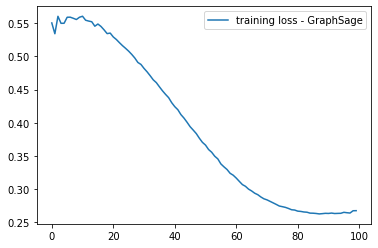

In [502]:
for args in [
    {'model_type': 'GraphSage', 'dataset': 'maze', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.5, 'epochs': 100, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 5e-3, 'lr': 0.001},
]:
    args = objectview(args)
    for model in ['GraphSage']:
        args.model_type = model

        # Match the dimension.
        if model == 'GAT':
            args.heads = 2
        else:
            args.heads = 1

        if args.dataset == 'maze':
            dataset = MazeDataset(data)
        else:
            raise NotImplementedError("Unknown dataset") 
        #losses = train(dataset, args) 
        test_loss, losses, best_model, best_loss, test_loader = train(dataset, args) 
        #print("Maximum test set accuracy: {0}".format(max(test_accs)))
        print("Minimum loss: {0}".format(min(losses)))

        # Run test for our best model to save the predictions!
        test(test_loader, best_model, is_validation=False, save_model_preds=False, model_type=model)
        print()

        #plt.title(dataset.name)
        plt.plot(losses, label="training loss" + " - " + args.model_type)
        #plt.plot(test_accs, label="test accuracy" + " - " + args.model_type)
    plt.legend()
    plt.show()

In [462]:
s = torch.tensor([[0.2212, 0.1667, 0.2114, 0.1914, 0.2093],
        [0.1951, 0.2095, 0.2019, 0.1803, 0.2133]])
s

tensor([[0.2212, 0.1667, 0.2114, 0.1914, 0.2093],
        [0.1951, 0.2095, 0.2019, 0.1803, 0.2133]])

In [467]:
s.max(axis=1)

torch.return_types.max(
values=tensor([0.2212, 0.2133]),
indices=tensor([0, 4]))

In [224]:
from torch_geometric.loader import DataLoader
loader = DataLoader([data], batch_size=32, shuffle = True,drop_last=True)

In [225]:
loader

In [247]:
for batch in loader:
    print(batch.x.shape)

AttributeError: 'dict' object has no attribute 'x'

In [227]:
batch

DataBatch(x=[60845, 2], edge_index=[2, 238606], edge_features=[238606, 2], batch=[60845], ptr=[2])

In [252]:
# this also works
from torch.utils.data import Dataset, DataLoader
class MyOwnDataset(Dataset):
    def __init__(self, data_obj, transform=None, pre_transform=None):
        super().__init__()
        self.data_obj = data_obj
    def __len__(self):
        return len(self.data_obj.x)
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = {'x':self.data_obj.x[idx], 'edge_index':self.data_obj.edge_index[:,idx], 'edge_features':self.data_obj.edge_features[idx,:]}
        #sample = Data(x=self.data_obj.x[idx], edge_index=self.data_obj.edge_index[:,idx], edge_features = self.data_obj.edge_features[idx,:]) #random sampled by the index. But... how does it handle searching neighborhood??
        return sample

In [230]:
data

Data(x=[60845, 2], edge_index=[2, 238606], edge_features=[238606, 2])

In [253]:
mazedataset = MyOwnDataset(data)

In [254]:
loader = DataLoader(mazedataset, batch_size=32, shuffle = True,drop_last=True)

In [255]:
for batch in loader:
    print(batch)

{'x': tensor([[140., 211.],
        [ 49., 286.],
        [130.,  69.],
        [167., 377.],
        [ 20.,  23.],
        [192.,  41.],
        [ 30., 308.],
        [ 98.,   9.],
        [ 81., 129.],
        [201., 118.],
        [199., 142.],
        [ 18., 312.],
        [ 47., 283.],
        [ 79., 208.],
        [  3.,  36.],
        [ 87.,  97.],
        [179., 356.],
        [131.,  91.],
        [150.,  62.],
        [100., 181.],
        [127., 188.],
        [ 55., 254.],
        [166., 185.],
        [129.,  31.],
        [  7., 233.],
        [ 60., 381.],
        [ 73., 293.],
        [ 69., 224.],
        [ 29., 336.],
        [ 69.,   3.],
        [ 52., 386.],
        [ 66., 205.]]), 'edge_index': tensor([[10279, 10278],
        [ 3610,  3277],
        [ 9557,  9343],
        [12272, 11964],
        [ 1517,  1518],
        [14006, 14327],
        [ 2281,  1948],
        [ 7106,  6773],
        [ 6083,  6082],
        [14709, 14388],
        [14544, 14543],
        [ 

{'x': tensor([[ 59., 317.],
        [144., 359.],
        [ 32.,  30.],
        [155.,  26.],
        [102., 273.],
        [113., 109.],
        [103.,  14.],
        [158., 334.],
        [ 80., 111.],
        [  3., 222.],
        [140., 247.],
        [ 39., 143.],
        [ 78., 212.],
        [ 36.,  33.],
        [ 25.,  61.],
        [175., 142.],
        [ 68., 338.],
        [123.,  80.],
        [110., 264.],
        [130., 297.],
        [147., 242.],
        [  7., 395.],
        [ 57., 193.],
        [ 21., 351.],
        [203., 276.],
        [ 83.,  54.],
        [  3., 167.],
        [  8., 201.],
        [ 21., 254.],
        [ 39., 166.],
        [152., 171.],
        [149., 173.]]), 'edge_index': tensor([[ 4425,  4758],
        [10666, 10390],
        [ 2365,  2364],
        [11416, 11108],
        [ 7390,  7723],
        [ 8275,  8501],
        [ 7424,  7425],
        [11708, 11709],
        [ 6012,  6011],
        [   62,    61],
        [10288, 10287],
        [ 

{'x': tensor([[ 90., 387.],
        [  5.,  13.],
        [185., 166.],
        [ 89.,  67.],
        [ 25., 382.],
        [163.,  71.],
        [193.,  78.],
        [166., 125.],
        [107., 176.],
        [187., 182.],
        [ 52., 252.],
        [ 20., 161.],
        [ 75., 125.],
        [162.,  86.],
        [190., 123.],
        [ 43., 349.],
        [205.,  18.],
        [ 55., 228.],
        [177., 105.],
        [200., 346.],
        [134.,  29.],
        [162., 107.],
        [210.,  73.],
        [ 63., 182.],
        [183., 137.],
        [139., 204.],
        [157., 387.],
        [ 13., 192.],
        [128., 383.],
        [140., 186.],
        [119.,   3.],
        [146., 183.]]), 'edge_index': tensor([[ 6755,  6754],
        [  227,   560],
        [13502, 13503],
        [ 6651,  6318],
        [ 2012,  2345],
        [12014, 12322],
        [14084, 14083],
        [12195, 11887],
        [ 7801,  7575],
        [13673, 13674],
        [ 3845,  3846],
        [ 

{'x': tensor([[123., 183.],
        [ 64.,  98.],
        [ 41., 113.],
        [ 62., 199.],
        [ 71., 295.],
        [ 62., 282.],
        [ 72., 113.],
        [ 88., 284.],
        [ 88., 139.],
        [ 39.,  20.],
        [  8., 199.],
        [200., 248.],
        [ 72.,   4.],
        [173., 262.],
        [  5.,  11.],
        [ 10., 204.],
        [138., 114.],
        [101.,  34.],
        [ 83., 209.],
        [ 54., 372.],
        [ 21.,  25.],
        [ 11., 121.],
        [ 32., 204.],
        [ 79.,  85.],
        [ 98., 264.],
        [ 18., 310.],
        [164.,   4.],
        [113.,  16.],
        [ 46., 161.],
        [161., 361.],
        [109.,  71.],
        [112.,  70.]]), 'edge_index': tensor([[ 9092,  9306],
        [ 4772,  4773],
        [ 2932,  2931],
        [ 4632,  4631],
        [ 5403,  5736],
        [ 4650,  4651],
        [ 5448,  5447],
        [ 6616,  6615],
        [ 6601,  6602],
        [ 2756,  2423],
        [  547,   548],
        [1

{'x': tensor([[158., 167.],
        [120., 191.],
        [161.,  66.],
        [195., 149.],
        [187., 152.],
        [195., 112.],
        [135., 149.],
        [ 43., 111.],
        [ 97.,  10.],
        [151., 236.],
        [180., 202.],
        [155., 393.],
        [172.,  30.],
        [175., 329.],
        [107., 201.],
        [204.,  42.],
        [200., 267.],
        [122., 194.],
        [  8.,  84.],
        [ 84.,  34.],
        [107.,  78.],
        [  4.,   8.],
        [141., 304.],
        [199., 223.],
        [ 55., 171.],
        [115., 209.],
        [ 78.,  95.],
        [ 75.,  62.],
        [ 85.,   8.],
        [157., 368.],
        [162., 293.],
        [105., 318.]]), 'edge_index': tensor([[11672, 11671],
        [ 8856,  8630],
        [11876, 11875],
        [14238, 14239],
        [13665, 13986],
        [14231, 13910],
        [ 9903,  9902],
        [ 3087,  2754],
        [ 7057,  7056],
        [11156, 10835],
        [13092, 12771],
        [1

{'x': tensor([[ 96., 178.],
        [ 16., 188.],
        [ 10., 280.],
        [172., 259.],
        [ 70., 314.],
        [ 67.,  44.],
        [ 99., 292.],
        [ 26., 317.],
        [138., 329.],
        [ 65., 115.],
        [164., 168.],
        [  6., 262.],
        [150.,  89.],
        [193., 173.],
        [ 64., 245.],
        [147.,  61.],
        [206., 312.],
        [ 70., 336.],
        [164.,  46.],
        [137.,  59.],
        [127., 357.],
        [148.,  61.],
        [120., 123.],
        [ 92., 284.],
        [200.,  97.],
        [193.,  68.],
        [ 44.,  45.],
        [151., 351.],
        [ 15., 358.],
        [ 77., 186.],
        [122., 248.],
        [105., 378.]]), 'edge_index': tensor([[ 7024,  6691],
        [ 1216,   883],
        [  733,   732],
        [12542, 12543],
        [ 5324,  5325],
        [ 5010,  4677],
        [ 7183,  7516],
        [ 2056,  2057],
        [10136,  9922],
        [ 4860,  4861],
        [12102, 12103],
        [ 

{'x': tensor([[  7., 308.],
        [ 61., 220.],
        [ 91., 284.],
        [152., 253.],
        [119., 216.],
        [ 10.,  87.],
        [120., 197.],
        [137., 349.],
        [ 51., 381.],
        [123., 386.],
        [ 96., 187.],
        [ 41., 381.],
        [ 98., 348.],
        [ 79., 119.],
        [ 87., 353.],
        [ 18., 388.],
        [194., 147.],
        [106.,  93.],
        [112., 296.],
        [210.,  78.],
        [114., 384.],
        [ 41., 347.],
        [ 95., 360.],
        [188., 144.],
        [148., 247.],
        [  6., 249.],
        [174.,  89.],
        [ 65., 183.],
        [161., 262.],
        [149., 363.],
        [113., 357.],
        [114.,  99.]]), 'edge_index': tensor([[  484,   151],
        [ 4556,  4223],
        [ 6784,  6785],
        [11234, 11233],
        [ 8784,  8558],
        [  690,   691],
        [ 8858,  8857],
        [10059,  9845],
        [ 3791,  3790],
        [ 9135,  9136],
        [ 7026,  7359],
        [ 

{'x': tensor([[187.,  10.],
        [ 30., 389.],
        [205., 353.],
        [ 78., 138.],
        [151.,  75.],
        [ 92., 307.],
        [190.,  74.],
        [207., 164.],
        [117., 304.],
        [146., 380.],
        [139.,  16.],
        [136., 209.],
        [ 17.,  33.],
        [  3., 310.],
        [191.,  16.],
        [161., 334.],
        [152.,  67.],
        [198., 305.],
        [207., 377.],
        [ 48., 198.],
        [ 61., 274.],
        [ 24., 198.],
        [ 80.,  84.],
        [144.,  43.],
        [196., 147.],
        [208., 277.],
        [207., 111.],
        [ 70., 111.],
        [ 17., 267.],
        [147., 341.],
        [207.,  61.],
        [115., 333.]]), 'edge_index': tensor([[13636, 13637],
        [ 2299,  2298],
        [15094, 15095],
        [ 5886,  5887],
        [11136, 11444],
        [ 6839,  6840],
        [13873, 13552],
        [15223, 15222],
        [ 8644,  8418],
        [10826, 10505],
        [10156,  9942],
        [ 

{'x': tensor([[  4., 123.],
        [ 26., 282.],
        [104., 307.],
        [ 74., 242.],
        [100., 128.],
        [ 58., 238.],
        [133., 293.],
        [ 74., 250.],
        [ 60., 106.],
        [130., 179.],
        [165., 301.],
        [137., 390.],
        [202., 159.],
        [  5., 303.],
        [149., 215.],
        [ 63., 254.],
        [123.,   9.],
        [ 16., 140.],
        [170., 391.],
        [ 50., 192.],
        [179.,  85.],
        [ 68., 117.],
        [156., 353.],
        [110.,   5.],
        [163.,  15.],
        [145., 393.],
        [ 35., 174.],
        [125.,  13.],
        [ 37., 339.],
        [108., 131.],
        [188., 342.],
        [ 45., 339.]]), 'edge_index': tensor([[  144,   477],
        [ 2050,  2383],
        [ 7588,  7587],
        [ 5645,  5646],
        [ 7213,  6880],
        [ 4327,  4328],
        [ 9786,  9785],
        [ 5647,  5648],
        [ 4456,  4457],
        [ 9579,  9365],
        [12165, 11857],
        [1

{'x': tensor([[201., 187.],
        [ 31., 274.],
        [195., 336.],
        [119., 270.],
        [190., 304.],
        [203.,  14.],
        [ 72., 268.],
        [103.,  95.],
        [ 89., 176.],
        [208., 243.],
        [ 19., 311.],
        [207., 234.],
        [131., 210.],
        [118., 118.],
        [ 37., 306.],
        [190., 187.],
        [ 39., 138.],
        [142.,  18.],
        [ 32., 186.],
        [163.,  75.],
        [138., 308.],
        [189., 220.],
        [197., 304.],
        [148., 323.],
        [ 25., 191.],
        [ 71.,  90.],
        [ 64., 300.],
        [147., 216.],
        [162., 119.],
        [198., 143.],
        [130., 222.],
        [ 22.,  70.]]), 'edge_index': tensor([[14724, 14725],
        [ 2333,  2666],
        [14261, 14582],
        [ 8795,  8569],
        [13907, 14228],
        [14854, 14533],
        [ 5480,  5813],
        [ 7443,  7442],
        [ 6676,  6677],
        [15323, 15002],
        [ 1493,  1494],
        [1

{'x': tensor([[ 12., 312.],
        [ 42.,  69.],
        [153., 229.],
        [177., 337.],
        [ 63., 284.],
        [ 68., 127.],
        [198., 348.],
        [ 81., 171.],
        [ 51., 224.],
        [110., 166.],
        [138.,  20.],
        [117.,  46.],
        [134., 151.],
        [ 90., 375.],
        [119., 228.],
        [ 44., 286.],
        [210., 100.],
        [ 36., 269.],
        [131.,  33.],
        [120., 117.],
        [ 22., 224.],
        [198.,  41.],
        [ 21., 392.],
        [159., 184.],
        [ 45., 290.],
        [ 47., 177.],
        [ 39., 249.],
        [ 43., 169.],
        [ 98., 165.],
        [197.,  12.],
        [175., 392.],
        [166., 311.]]), 'edge_index': tensor([[  905,   906],
        [ 3002,  3001],
        [11300, 11301],
        [12893, 13214],
        [ 4729,  4728],
        [ 5115,  4782],
        [14503, 14504],
        [ 6090,  5757],
        [ 3757,  3424],
        [ 8043,  8044],
        [10073, 10074],
        [ 

{'x': tensor([[ 20.,  65.],
        [  4., 354.],
        [208., 187.],
        [ 50., 274.],
        [139.,   7.],
        [ 80., 176.],
        [134., 178.],
        [181.,  76.],
        [ 94., 140.],
        [203., 166.],
        [193.,  37.],
        [ 16., 185.],
        [183., 211.],
        [152., 372.],
        [157., 323.],
        [203., 234.],
        [203., 114.],
        [ 94., 175.],
        [ 14., 111.],
        [147., 328.],
        [181., 352.],
        [ 37., 391.],
        [ 54., 221.],
        [ 99., 293.],
        [102., 101.],
        [109., 266.],
        [ 87., 220.],
        [ 41.,  72.],
        [152., 184.],
        [ 27.,  27.],
        [ 72., 129.],
        [ 78., 223.]]), 'edge_index': tensor([[ 1524,  1857],
        [  214,   213],
        [15312, 14991],
        [ 3688,  4021],
        [10154, 10155],
        [ 6025,  6026],
        [ 9841, 10055],
        [13151, 13472],
        [ 6918,  6585],
        [14887, 14886],
        [14076, 14077],
        [ 

{'x': tensor([[174., 368.],
        [109., 125.],
        [201., 248.],
        [196., 351.],
        [  3., 182.],
        [197., 332.],
        [ 32.,  59.],
        [157., 116.],
        [  6., 319.],
        [106.,  89.],
        [206., 168.],
        [187.,  45.],
        [186., 213.],
        [131., 206.],
        [150., 313.],
        [191., 374.],
        [113., 181.],
        [207.,  96.],
        [ 83., 132.],
        [168., 106.],
        [ 68.,  73.],
        [173., 167.],
        [139., 228.],
        [ 69., 102.],
        [122., 358.],
        [143.,  76.],
        [ 68., 272.],
        [114., 183.],
        [ 47., 271.],
        [194., 211.],
        [ 90., 305.],
        [158., 365.]]), 'edge_index': tensor([[12687, 12686],
        [ 7954,  7955],
        [14736, 14415],
        [14334, 14655],
        [   52,   385],
        [14415, 14414],
        [ 2369,  2370],
        [11578, 11270],
        [  403,    70],
        [ 7701,  7700],
        [15140, 15141],
        [1

{'x': tensor([[142.,  65.],
        [141., 202.],
        [ 73., 135.],
        [165.,  72.],
        [ 22.,  22.],
        [127., 387.],
        [139.,  79.],
        [ 79., 237.],
        [167., 299.],
        [152.,  71.],
        [  6., 176.],
        [195.,  86.],
        [ 71.,  57.],
        [ 12.,  38.],
        [124., 112.],
        [  9., 193.],
        [ 90., 292.],
        [ 43., 162.],
        [ 14., 200.],
        [ 87.,  69.],
        [ 19., 285.],
        [117., 355.],
        [ 54., 108.],
        [ 58., 276.],
        [  4., 320.],
        [ 51.,  31.],
        [144.,  88.],
        [ 44., 260.],
        [ 23., 322.],
        [177., 362.],
        [ 10.,  73.],
        [ 26., 374.]]), 'edge_index': tensor([[10434, 10433],
        [10361, 10360],
        [ 5537,  5538],
        [12134, 12135],
        [ 1685,  1684],
        [ 9414,  9413],
        [10169, 10445],
        [ 5974,  5641],
        [12265, 12264],
        [11208, 10887],
        [  373,    40],
        [1

{'x': tensor([[ 36., 169.],
        [ 27.,  90.],
        [ 79.,  32.],
        [194.,  91.],
        [121., 178.],
        [ 10.,  35.],
        [109., 100.],
        [ 53., 294.],
        [ 80.,  10.],
        [ 27., 266.],
        [ 40., 378.],
        [182., 316.],
        [142., 128.],
        [160., 306.],
        [185., 204.],
        [ 24.,  42.],
        [ 70.,  97.],
        [ 36.,  63.],
        [ 46., 393.],
        [  3., 350.],
        [  9., 178.],
        [153., 307.],
        [122., 317.],
        [139.,  64.],
        [185.,  81.],
        [144., 225.],
        [157.,   9.],
        [159., 170.],
        [111., 113.],
        [ 43., 159.],
        [145., 295.],
        [  4., 235.]]), 'edge_index': tensor([[ 2594,  2595],
        [ 2092,  1759],
        [ 5925,  6258],
        [14157, 14158],
        [ 8931,  8705],
        [  680,   681],
        [ 7948,  7947],
        [ 3936,  3603],
        [ 5989,  5656],
        [ 2103,  2436],
        [ 2908,  3241],
        [1

{'x': tensor([[171., 301.],
        [172., 105.],
        [196., 217.],
        [ 54., 287.],
        [102., 263.],
        [ 13., 222.],
        [ 52., 144.],
        [199.,  90.],
        [ 65., 135.],
        [ 48., 120.],
        [179.,  25.],
        [ 73., 345.],
        [ 64., 129.],
        [199.,  59.],
        [ 13., 333.],
        [187., 375.],
        [  9., 235.],
        [122.,  31.],
        [ 78., 245.],
        [ 13., 373.],
        [ 46., 384.],
        [ 36., 386.],
        [ 60., 300.],
        [ 22., 256.],
        [ 37., 313.],
        [117., 135.],
        [ 49., 383.],
        [193.,  60.],
        [180., 122.],
        [ 87.,  46.],
        [ 15.,  79.],
        [ 19., 384.]]), 'edge_index': tensor([[12484, 12485],
        [12509, 12510],
        [14321, 14322],
        [ 4016,  4015],
        [ 7388,  7389],
        [  969,  1302],
        [ 3820,  4153],
        [14534, 14533],
        [ 4865,  4866],
        [ 3490,  3823],
        [12985, 12984],
        [ 

{'x': tensor([[161., 125.],
        [ 36., 188.],
        [208., 141.],
        [165., 181.],
        [ 87.,  74.],
        [147., 385.],
        [163., 307.],
        [208., 385.],
        [181.,   3.],
        [  4., 245.],
        [168., 374.],
        [  5.,  10.],
        [118.,  93.],
        [119., 245.],
        [ 51.,  81.],
        [166., 108.],
        [ 15.,  46.],
        [ 75., 224.],
        [117., 358.],
        [176.,  40.],
        [154.,  32.],
        [179., 137.],
        [ 66.,  40.],
        [190., 155.],
        [177., 316.],
        [189.,  16.],
        [204., 292.],
        [115.,  99.],
        [ 10., 281.],
        [206.,  63.],
        [ 62., 313.],
        [ 24., 387.]]), 'edge_index': tensor([[11887, 12195],
        [ 2599,  2598],
        [15301, 15300],
        [12156, 11848],
        [ 6500,  6833],
        [10900, 10579],
        [12046, 12354],
        [15354, 15353],
        [13136, 12815],
        [  182,   181],
        [12321, 12642],
        [ 

{'x': tensor([[198.,  75.],
        [ 71., 277.],
        [113.,  87.],
        [132., 332.],
        [148., 242.],
        [199.,  84.],
        [142., 370.],
        [206.,  38.],
        [ 70., 358.],
        [ 88.,  52.],
        [ 56., 149.],
        [133., 110.],
        [112., 309.],
        [176.,  60.],
        [186., 110.],
        [199., 298.],
        [139.,  36.],
        [114., 291.],
        [ 68., 294.],
        [131., 211.],
        [ 67., 381.],
        [186., 384.],
        [185., 382.],
        [150., 391.],
        [ 52., 344.],
        [ 88., 300.],
        [197.,   5.],
        [180., 211.],
        [ 95., 183.],
        [ 53.,  42.],
        [209., 395.],
        [ 35., 333.]]), 'edge_index': tensor([[14446, 14125],
        [ 5399,  5400],
        [ 8270,  8271],
        [ 9727,  9728],
        [10942, 11250],
        [14532, 14211],
        [10499, 10820],
        [15113, 15434],
        [ 5332,  5665],
        [ 6579,  6246],
        [ 4146,  4145],
        [ 

{'x': tensor([[163., 300.],
        [187., 382.],
        [203., 386.],
        [185., 111.],
        [181., 115.],
        [122., 200.],
        [  8., 189.],
        [122., 278.],
        [106.,  99.],
        [ 39., 231.],
        [ 98., 343.],
        [ 41., 108.],
        [ 10., 373.],
        [ 67., 282.],
        [143., 109.],
        [ 69.,  10.],
        [168., 110.],
        [194.,  76.],
        [ 66., 275.],
        [ 64.,  66.],
        [169.,  43.],
        [106., 373.],
        [ 61., 378.],
        [157.,  16.],
        [  3., 306.],
        [ 40., 179.],
        [ 87., 197.],
        [204., 178.],
        [ 35., 172.],
        [ 17.,  22.],
        [127., 150.],
        [103., 236.]]), 'edge_index': tensor([[12045, 12044],
        [13714, 14035],
        [14933, 14932],
        [13491, 13170],
        [13158, 12837],
        [ 9018,  9232],
        [  544,   877],
        [ 9035,  9036],
        [ 7704,  7703],
        [ 2800,  2801],
        [ 7143,  7476],
        [ 

{'x': tensor([[181., 260.],
        [106., 217.],
        [195.,  36.],
        [ 22., 320.],
        [ 60., 287.],
        [ 54., 290.],
        [ 36., 387.],
        [  4., 395.],
        [183.,  68.],
        [116.,  98.],
        [115.,  73.],
        [201., 239.],
        [ 31., 388.],
        [ 78.,  66.],
        [103., 186.],
        [101., 305.],
        [186., 164.],
        [154., 358.],
        [173.,  38.],
        [ 16., 278.],
        [ 81., 110.],
        [ 66., 244.],
        [197., 215.],
        [202., 206.],
        [ 85., 222.],
        [108., 349.],
        [200., 245.],
        [ 86., 347.],
        [123.,  83.],
        [176., 292.],
        [ 12., 194.],
        [ 81.,  56.]]), 'edge_index': tensor([[13186, 13187],
        [ 7730,  7397],
        [14215, 13894],
        [ 1748,  1749],
        [ 4495,  4162],
        [ 4016,  4349],
        [ 2625,  2292],
        [  224,   223],
        [13311, 13312],
        [ 8516,  8742],
        [ 8429,  8430],
        [1

{'x': tensor([[  3., 273.],
        [ 60.,  62.],
        [ 20., 247.],
        [ 29., 322.],
        [ 19., 385.],
        [133., 203.],
        [107., 293.],
        [ 15., 389.],
        [177., 177.],
        [ 39., 377.],
        [ 43., 199.],
        [201., 382.],
        [141., 295.],
        [185., 248.],
        [ 51., 349.],
        [153., 391.],
        [ 54., 138.],
        [ 30., 307.],
        [105., 192.],
        [ 22., 376.],
        [ 38., 373.],
        [167.,  72.],
        [191., 330.],
        [108., 190.],
        [146., 257.],
        [175., 263.],
        [119., 148.],
        [  6., 379.],
        [134.,  75.],
        [ 51., 132.],
        [127., 126.],
        [121., 176.]]), 'edge_index': tensor([[   79,   412],
        [ 4448,  4449],
        [ 1564,  1565],
        [ 2228,  2227],
        [ 1509,  1508],
        [ 9779,  9565],
        [ 7828,  7829],
        [ 1174,  1173],
        [12862, 13183],
        [ 2827,  3160],
        [ 3109,  2776],
        [1

{'x': tensor([[157., 264.],
        [ 22.,  85.],
        [ 22.,   3.],
        [ 90.,  41.],
        [128., 211.],
        [ 11., 380.],
        [ 12., 285.],
        [149.,  20.],
        [188., 208.],
        [ 39., 139.],
        [ 15.,  35.],
        [138., 345.],
        [157., 306.],
        [210., 367.],
        [112.,  11.],
        [130.,  44.],
        [193., 105.],
        [101., 172.],
        [ 69., 198.],
        [ 11.,  16.],
        [123., 301.],
        [ 66.,   6.],
        [151., 254.],
        [126., 380.],
        [ 40., 138.],
        [116., 343.],
        [ 88., 113.],
        [132.,   4.],
        [ 53.,  13.],
        [ 65., 277.],
        [  9., 106.],
        [ 10., 316.]]), 'edge_index': tensor([[11610, 11609],
        [ 1697,  2030],
        [ 1680,  1681],
        [ 6713,  7046],
        [ 9454,  9453],
        [  835,  1168],
        [  901,  1234],
        [10983, 10982],
        [13762, 13761],
        [ 2780,  2781],
        [ 1100,   767],
        [1

{'x': tensor([[ 80., 109.],
        [108., 216.],
        [115., 349.],
        [ 54., 198.],
        [103.,   3.],
        [187., 387.],
        [ 81., 203.],
        [118., 173.],
        [ 73.,  98.],
        [ 11.,  74.],
        [192.,   6.],
        [ 54., 280.],
        [ 11., 238.],
        [ 40., 381.],
        [ 79., 373.],
        [161., 302.],
        [203.,  29.],
        [ 49., 163.],
        [ 51., 299.],
        [108.,  46.],
        [ 30., 328.],
        [164.,  41.],
        [ 85., 353.],
        [ 14., 231.],
        [172., 252.],
        [ 61.,  77.],
        [121., 273.],
        [ 70., 108.],
        [124., 144.],
        [171., 132.],
        [ 14., 262.],
        [179., 347.]]), 'edge_index': tensor([[ 6011,  5678],
        [ 7893,  7894],
        [ 8490,  8491],
        [ 3996,  4329],
        [ 7420,  7087],
        [13716, 13715],
        [ 6098,  5765],
        [ 8695,  8469],
        [ 5528,  5527],
        [  771,   772],
        [13998, 13997],
        [ 

{'x': tensor([[  4., 224.],
        [112., 124.],
        [195., 178.],
        [205.,  92.],
        [ 19., 110.],
        [ 10.,  28.],
        [174., 231.],
        [202., 154.],
        [200., 345.],
        [167., 146.],
        [ 30., 313.],
        [ 57., 381.],
        [187., 208.],
        [197., 105.],
        [ 46., 282.],
        [ 78., 395.],
        [ 66., 271.],
        [129., 138.],
        [ 13., 120.],
        [163., 265.],
        [ 88., 386.],
        [ 74., 106.],
        [140., 262.],
        [ 73., 166.],
        [201.,  41.],
        [ 66., 122.],
        [ 60., 181.],
        [ 42.,  68.],
        [ 39., 343.],
        [192., 374.],
        [154., 305.],
        [102., 118.]]), 'edge_index': tensor([[  174,   175],
        [ 8198,  8199],
        [14245, 13924],
        [15039, 14718],
        [ 1449,  1450],
        [  678,   345],
        [12658, 12979],
        [14800, 14801],
        [14670, 14669],
        [12250, 12571],
        [ 2282,  2615],
        [ 

{'x': tensor([[204., 270.],
        [ 70., 342.],
        [ 54.,  40.],
        [ 52.,  68.],
        [192.,  19.],
        [ 38., 131.],
        [ 52., 381.],
        [ 52.,  70.],
        [ 54.,  83.],
        [196., 118.],
        [136., 119.],
        [ 46., 284.],
        [182.,  35.],
        [ 69., 340.],
        [ 43., 315.],
        [ 21.,  88.],
        [103., 192.],
        [ 97., 301.],
        [ 89., 314.],
        [163., 316.],
        [ 35.,   6.],
        [105., 312.],
        [140., 372.],
        [127.,  76.],
        [ 52.,  17.],
        [126., 390.],
        [206., 123.],
        [194., 203.],
        [153., 293.],
        [ 18., 383.],
        [ 65., 223.],
        [196., 361.]]), 'edge_index': tensor([[14990, 15311],
        [ 5328,  5661],
        [ 3962,  3963],
        [ 3804,  4137],
        [14001, 14002],
        [ 2708,  3041],
        [ 3871,  4204],
        [ 3805,  3806],
        [ 3970,  3969],
        [14302, 13981],
        [ 9961,  9960],
        [ 

{'x': tensor([[ 72.,  37.],
        [200., 388.],
        [ 96., 335.],
        [146.,  77.],
        [ 65., 376.],
        [103., 106.],
        [ 48.,  78.],
        [207., 123.],
        [187.,  99.],
        [183., 374.],
        [188.,  89.],
        [ 64., 268.],
        [ 21.,  62.],
        [ 20., 142.],
        [151., 174.],
        [193., 208.],
        [ 53., 141.],
        [133., 121.],
        [126., 381.],
        [ 56.,  34.],
        [ 34.,   4.],
        [209.,  43.],
        [151., 256.],
        [144., 128.],
        [197., 329.],
        [ 85.,  68.],
        [140., 356.],
        [187., 365.],
        [194., 178.],
        [132.,   5.],
        [185., 311.],
        [ 87., 288.]]), 'edge_index': tensor([[ 5429,  5428],
        [14680, 15001],
        [ 7042,  7375],
        [10765, 10766],
        [ 4914,  4915],
        [ 7446,  7113],
        [ 3483,  3484],
        [15215, 15536],
        [13655, 13334],
        [13376, 13377],
        [13737, 13738],
        [ 

{'x': tensor([[140., 290.],
        [164., 316.],
        [181.,   9.],
        [147., 268.],
        [  8., 166.],
        [ 22., 172.],
        [  5., 223.],
        [181.,  20.],
        [ 34., 341.],
        [154., 387.],
        [208., 281.],
        [206., 208.],
        [193.,  72.],
        [183., 332.],
        [104.,  92.],
        [153., 363.],
        [185., 158.],
        [103.,  74.],
        [115., 309.],
        [139., 121.],
        [  3.,  76.],
        [ 32.,  32.],
        [121., 191.],
        [ 19., 309.],
        [107., 203.],
        [204., 380.],
        [195.,  19.],
        [ 72., 142.],
        [151., 341.],
        [183., 233.],
        [ 39.,  67.],
        [199., 375.]]), 'edge_index': tensor([[10295, 10571],
        [12118, 12439],
        [13138, 13137],
        [10873, 11194],
        [  539,   538],
        [ 1717,  1716],
        [  286,   287],
        [13140, 13461],
        [ 2508,  2841],
        [11408, 11100],
        [15330, 15009],
        [1

{'x': tensor([[153.,  70.],
        [ 67.,  74.],
        [ 65., 114.],
        [142., 106.],
        [124., 354.],
        [184., 253.],
        [ 60.,  14.],
        [ 22., 353.],
        [126., 120.],
        [ 86.,  43.],
        [ 87., 310.],
        [119., 150.],
        [149.,  84.],
        [159., 301.],
        [ 26., 186.],
        [138., 140.],
        [ 70., 302.],
        [ 23.,  23.],
        [ 13., 231.],
        [ 12.,  73.],
        [ 44., 133.],
        [144.,  29.],
        [ 63., 110.],
        [ 28., 189.],
        [ 49.,  37.],
        [ 84., 273.],
        [208., 312.],
        [163., 273.],
        [133., 295.],
        [ 74., 266.],
        [204.,  74.],
        [ 96., 295.]]), 'edge_index': tensor([[11281, 10973],
        [ 5018,  5017],
        [ 4860,  4859],
        [10442, 10443],
        [ 9208,  9422],
        [13436, 13437],
        [ 4442,  4109],
        [ 1756,  1423],
        [ 9312,  9313],
        [ 6409,  6742],
        [ 6554,  6555],
        [ 

{'x': tensor([[ 54., 175.],
        [108., 122.],
        [179., 240.],
        [ 58.,  86.],
        [  5., 166.],
        [148., 178.],
        [154., 382.],
        [ 18., 201.],
        [192.,  85.],
        [157., 236.],
        [194., 331.],
        [119., 213.],
        [193.,  64.],
        [ 75., 144.],
        [ 59., 146.],
        [209., 300.],
        [ 54., 180.],
        [123.,  40.],
        [118., 356.],
        [127., 212.],
        [ 31.,  44.],
        [ 60.,  86.],
        [ 25., 140.],
        [208.,  27.],
        [ 72.,  53.],
        [ 82., 229.],
        [ 25., 170.],
        [194., 371.],
        [ 39.,  46.],
        [ 73., 380.],
        [135., 291.],
        [ 53., 264.]]), 'edge_index': tensor([[ 3990,  3657],
        [ 7872,  7873],
        [13023, 13344],
        [ 4294,  4627],
        [  271,   272],
        [10929, 10930],
        [11407, 11408],
        [ 1388,  1389],
        [14015, 14016],
        [11603, 11602],
        [14191, 14190],
        [ 

{'x': tensor([[ 19., 262.],
        [ 83., 121.],
        [157.,   3.],
        [ 93., 144.],
        [155., 390.],
        [135., 141.],
        [ 19., 248.],
        [100., 220.],
        [114., 272.],
        [ 64., 139.],
        [189., 218.],
        [176., 120.],
        [ 77., 184.],
        [ 57., 223.],
        [156., 271.],
        [ 18., 229.],
        [ 62.,  84.],
        [ 24.,  87.],
        [ 43., 254.],
        [160., 349.],
        [128., 152.],
        [160., 342.],
        [157., 112.],
        [  8., 260.],
        [ 22., 392.],
        [ 32., 274.],
        [105., 228.],
        [121., 279.],
        [152.,  89.],
        [ 33., 337.],
        [158., 136.],
        [  6.,  90.]]), 'edge_index': tensor([[ 1484,  1485],
        [ 6212,  5879],
        [11556, 11557],
        [ 6869,  7202],
        [11481, 11173],
        [ 9901,  9900],
        [ 1480,  1813],
        [ 7233,  6900],
        [ 8392,  8393],
        [ 4782,  4449],
        [13834, 13513],
        [1

{'x': tensor([[ 56., 107.],
        [ 53., 296.],
        [ 37., 310.],
        [160., 137.],
        [ 12., 131.],
        [184., 216.],
        [ 59., 239.],
        [185.,   9.],
        [ 14., 377.],
        [144., 176.],
        [179.,  21.],
        [188.,  80.],
        [194., 298.],
        [114., 297.],
        [166., 267.],
        [ 30., 381.],
        [120., 140.],
        [166., 146.],
        [125., 211.],
        [ 99., 182.],
        [ 94., 389.],
        [118., 381.],
        [206., 119.],
        [ 19., 145.],
        [175., 330.],
        [169., 167.],
        [ 17., 285.],
        [132., 176.],
        [ 16., 374.],
        [118., 375.],
        [ 58., 183.],
        [104., 351.]]), 'edge_index': tensor([[ 4135,  3802],
        [ 3937,  3936],
        [ 2666,  2333],
        [11821, 11820],
        [  866,   867],
        [13427, 13426],
        [ 4406,  4407],
        [13468, 13147],
        [ 1087,  1420],
        [10626, 10627],
        [12984, 12983],
        [1

{'x': tensor([[ 81., 389.],
        [ 44., 268.],
        [ 54., 113.],
        [ 95., 271.],
        [161., 351.],
        [107., 245.],
        [ 43., 165.],
        [128.,  92.],
        [110., 134.],
        [ 29., 183.],
        [ 12., 382.],
        [ 76., 247.],
        [102., 287.],
        [ 27., 320.],
        [ 94.,  36.],
        [103., 246.],
        [123., 297.],
        [141., 105.],
        [ 14., 154.],
        [171., 253.],
        [  7., 189.],
        [ 36., 345.],
        [ 72., 298.],
        [ 59., 186.],
        [ 72., 291.],
        [109., 122.],
        [  4., 303.],
        [ 75., 394.],
        [135., 314.],
        [ 12., 258.],
        [138.,  64.],
        [  9., 306.]]), 'edge_index': tensor([[ 6118,  5785],
        [ 3201,  3202],
        [ 3975,  3974],
        [ 6979,  6646],
        [11920, 12228],
        [ 7819,  7820],
        [ 3101,  3100],
        [ 9432,  9646],
        [ 8038,  8039],
        [ 2210,  2543],
        [  920,   587],
        [ 

{'x': tensor([[ 86., 305.],
        [187.,  70.],
        [209., 386.],
        [174.,  85.],
        [190.,  29.],
        [178., 271.],
        [ 67., 334.],
        [204., 138.],
        [ 19., 275.],
        [188.,  31.],
        [ 64., 340.],
        [150., 226.],
        [ 26., 321.],
        [121., 122.],
        [120.,  72.],
        [187., 379.],
        [102., 144.],
        [ 70., 231.],
        [ 89., 100.],
        [ 66.,  76.],
        [ 12., 240.],
        [ 68.,  10.],
        [179., 337.],
        [ 51., 240.],
        [ 40., 115.],
        [143., 363.],
        [ 59.,   7.],
        [120., 385.],
        [175.,  73.],
        [  9., 350.],
        [ 16., 260.],
        [195., 161.]]), 'edge_index': tensor([[ 6469,  6470],
        [13648, 13649],
        [15439, 15438],
        [12634, 12635],
        [13865, 13866],
        [12954, 12955],
        [ 5075,  5074],
        [14963, 14964],
        [ 1487,  1154],
        [13725, 14046],
        [ 4823,  5156],
        [1

In [217]:
model = GNNStack(2, args.hidden_dim, 20, args)

In [256]:
model.forward(batch)

AttributeError: 'dict' object has no attribute 'x'

In [220]:
batch.batch.shape

torch.Size([60845])

In [221]:
batch.x

tensor([[  3.,   3.],
        [  3.,   4.],
        [  3.,   5.],
        ...,
        [210., 393.],
        [210., 394.],
        [210., 395.]])

In [223]:
batch.edge_index.shape

torch.Size([2, 238606])

In [231]:
from torch_geometric.datasets import Planetoid
coradataset = Planetoid(root='/tmp/cora', name='Cora')

In [232]:
coradataset.data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [237]:
data.edge_index[:,:10]

tensor([[  0,   0,   1,   1,   1,   2,   2,   2,   3,   3],
        [  1, 333,   0,   2, 334,   1,   3, 335,   2,   4]])

In [440]:
from torch_geometric.data import InMemoryDataset, Data
from sklearn.model_selection import train_test_split

class MazeDataset(InMemoryDataset):
    def __init__(self, data_obj, transform=None):
        super(MazeDataset, self).__init__(data_obj, transform, None, None)
        self.data_obj = data_obj
        
        self.data_obj.num_nodes = len(self.data_obj.x)
        #normalize x
        original_x = copy.deepcopy(self.data_obj.x)
        self.data_obj['scaler'] = original_x.max()-original_x.min()
        self.data_obj['shift'] = original_x.mean()
        self.data_obj.x = (original_x-self.data_obj['shift'])/self.data_obj['scaler']
        # splitting the data into train, validation and test
        X_train, X_test = train_test_split(pd.Series(range(self.data_obj.num_nodes)), 
                                                            test_size=0.30, 
                                                            random_state=42)
        
        
        # create train and test masks for data
        train_mask = torch.zeros(self.data_obj.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(self.data_obj.num_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        self.data_obj['train_mask'] = train_mask
        self.data_obj['test_mask'] = test_mask

        self.data, self.slices = self.collate([self.data_obj])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [439]:
dataset.data.x.mean()

tensor(153.0338)

In [269]:
mazedataset = MazeDataset(data)

In [301]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
loader = DataLoader(mazedataset, batch_size=32, shuffle = True,drop_last=True)

In [302]:
for batch in loader:
    print(batch)

In [303]:
batch.batch

AttributeError: 'dict' object has no attribute 'batch'

In [287]:
from torch_geometric.datasets import KarateClub
from torch_geometric.data import DataLoader 

In [289]:
karatedata = KarateClub()

In [291]:
karatedata.data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [292]:
loader = DataLoader(karatedata, batch_size=4, shuffle = True,drop_last=True)

/opt/anaconda3/envs/sptm2/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [293]:
for batch in loader:
    print(batch)

In [295]:
batch.x

AttributeError: 'dict' object has no attribute 'x'

In [350]:
from torch_geometric.data import DataLoader
#loader = DataLoader(coradataset, batch_size=32, shuffle = True,drop_last=True)
loader2 = DataLoader(coradataset, batch_size=32, shuffle=False)

In [351]:
for batch in loader2:
    print(batch)

DataBatch(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], batch=[2708], ptr=[2])


In [325]:
batch.batch

tensor(0)